# ARIMA Models I: Random walks, MA, AR, and ARMA
#### 2023/05/29, AJ Zerouali

General goals of this notebook (and the next one(s)):
* Get acquainted with various ARIMA model implementations in Python.
* Test the functioning on some financial data.

As starting points, we use the following references:
* Peixeiro, "Time Series Forecasting in Python". The Github repo for examples is here: https://github.com/marcopeix/TimeSeriesForecastingInPython.
* The *statsmodels* time series analysis module and its examples:
https://www.statsmodels.org/stable/examples/index.html#time-series-analysis

In this particular notebook, we will start slow with stationary time series models. As a reference, we'll start with Chapters 3-7 of Peixeiro's book, which cover random walks, moving average, autoregressive, and ARMA models. 


**Log Comments:**
* 23/05/23 - 14:21: I think that something is wrong with the statsmodels parameter estimation. Even when I use their package functions to generate a synthetic MA(5) model with prescribed parameters, their *model.fit()* methods (for both ARIMA and SARIMAX) give me some outlandish moving average parameters, which have nothing to do with my input.
* 23/05/25 - 17:15: Starting 23/05/24, Paperspace underwent several major disruptions following infrastructure updates. I had to use Colab on the side a lot. The plan starting today is to clarify the following topics:
    1) **Model selection:** Meaning how to choose an $ARIMA(p,d,q)$ model given a time series. We've covered Ch.3-4 of Peixeiro for stationarity and the $MA(q)$ order. Today (23/05/25) we continue by covering Ch.5-7 of this book.
    2) **Forecasting techniques:** At the time of writing I don't have a definite answer on how this should be done properly. 
    3) **Performance metrics:** Essentially baselines and metrics for the comparison of forecasts.

    Today at least, I am covering:

    * Autoregressive processes $AR(p)$ and the PACF
    * Statistics for $ARMA(p,q)$ processes
    * Forecasting baselines and metrics
    
__________________________________________________________

## COLAB SETUP

**Mount drive and change PWD**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks/Time_Series_RL_Research

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Time_Series_RL_Research


**CRUCIAL - INSTALL REQUIREMENTS**

In [2]:
!chmod 762 pfopt_env_setup.sh
!./pfopt_env_setup.sh

########################################################
########### Setting-up DRL_PFOpt environment ###########
########################################################

###########################
##### Updating PIP... #####
###########################
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

###############################
##### Updating PyTorch... #####
###############################
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB ? eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflict

In [ ]:
!pip install "sb3-contrib https://github.com/Stable-Baselines-Team/stable-baselines3-contrib@feat/new-gym-version"

ERROR: Invalid requirement: 'sb3-contrib https://github.com/Stable-Baselines-Team/stable-baselines3-contrib@feat/new-gym-version'
Hint: It looks like a path. File 'sb3-contrib https://github.com/Stable-Baselines-Team/stable-baselines3-contrib@feat/new-gym-version' does not exist.


In [ ]:
!pip install sb3-contrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sb3_contrib-1.8.0-py3-none-any.whl (79 kB)
  Using cached stable_baselines3-1.8.0-py3-none-any.whl (174 kB)
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.8/915.8 kB 16.8 MB/s eta 0:00:00


## Data and Train-Test Environments

In [1]:
# GLOBAL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date
import gym
# deque and random
from collections import deque
import random
#import sys
import torch as th
from torch import nn
from torch import optim
from drl_pfopt import (PortfolioOptEnv, FeatureEngineer, data_split, AlpacaDownloader, YahooDownloader)
# NOTE 23/05/16 - COLAB version: I've removed the import of sb3-contrib from base_agent.py in drl_pfopt.
# I'm also unable to find a fork of sb3_contrib that's compatible with the sb3 fork
# that I am using right now.
from dual_timeframe_XP import (PFOptDualTFEnv, FeatureEngDualTF, data_dict_split)


/usr/local/lib/python3.9/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


#### Statsmodels imports

In [2]:
# Autocorrelation functions (ACF and PACF plotters)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller 
# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
# SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# ARIMA model (Although we'll just look at the ARMA part)
from statsmodels.tsa.arima_process import ArmaProcess, arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA


In [3]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm

**Auto ARIMA**

In [4]:
# Auto ARIMA function
from pmdarima import auto_arima

**Helper functions**

Functions I wrote for this notebook. Ensure Time_Series_Helpers.py is imported properly

In [5]:
from Time_Series_Helpers import plot_forecasts, get_daily_stock_returns, ARMA_grid_search

#### Plotting function

It will be useful to have a plotting function for our forecasts. We'll write it so that it also prints out the MSE of the predictions compared to the test data.

In [12]:
def plot_forecasts(Y_train: np.ndarray,
                   n_train_plot_pts: int,
                   Y_test: np.ndarray,
                   Y_pred: np.ndarray,
                   n_forecast_plot_pts: int,
                   fig_title: str = "Original process and forecasts",
                   legend_loc: int = 1,
                   x_label: str = "Time",
                   y_label: str = "Y",
                   Y_pred_conf_int: np.ndarray = None,
                   plot_confidence_band: bool = False,
                   plot_upper_lower_curves: bool = False,
                  ):
    '''
        :param Y_train: np.ndarray, training data
        :param n_train_pts: int, number of points to plot from training data
        :param Y_test: np.ndarray, test data
        :param Y_pred: np.ndarray, out-of-sample forecasts
        :param n_forecast_pts: int, no. of points to plot from test data and forecasts
        :param fig_title: str, title of the figure
        :param legend_loc: int = 1,
        :param x_label: str = "Time", self-explanatory
        :param y_label: str = "Y", self-explanatory
        :param Y_pred_conf_int: np.ndarray = None, confidence interval start and end points.
                    If Y_pred.shape = (N,), should have Y_pred_conf_int.shape = (N,2),
                    with Y_pred_conf_int[:,0] giving the lower bound of the conf. interval
                    and  Y_pred_conf_int[:,1] giving the upper bound of the conf. interval
        :param plot_confidence_band: bool = False, whether or not to plot the confidence band
        :param plot_upper_lower_curves: bool = False, whetehr or not to not the upper and lower bounds
    '''
    # Initializations
    n_train_pts = len(Y_train)
    n_test_pts = len(Y_test)
    n_forecast_pts = len(Y_pred)
    
    # Check lengths and shapes
    if n_train_pts<n_train_plot_pts:
        raise ValueError(f"n_train_plot_pts = {n_train_plot_pts} is greater than len(Y_train) = {len(Y_train)}")
    if (Y_train.shape != (n_train_pts,)) or (Y_test.shape != (n_test_pts,)) or (Y_pred.shape != (n_forecast_pts,)):
        raise ValueError("The parameters Y_train, Y_test, and Y_pred must all be one-dimensional arrays.")
    if n_forecast_plot_pts>n_forecast_pts:
        raise ValueError(f"n_forecast_plot_pts = {n_forecast_plot_pts} is greater than len(Y_pred) = {len(Y_pred)}")
    if plot_confidence_band:
        if Y_pred_conf_int.shape != (n_forecast_pts,2):
            print(f"WARNING: Will not plot confidence band, param. Y_pred_conf_int has wrong shape.\n"\
                  f"Plotting the confidence band requires Y_pred_conf_int.shape = (len(Y_pred),2)"
                 )
            plot_confidence_band = False
    
    # Make x-axis ranges for sample and out-of-sample data
    #x_plot_start = n_train_pts - n_train_plot_pts
    x_sample = np.arange(n_train_pts - n_train_plot_pts, n_train_pts)
    x_oos_data = np.arange(n_train_pts, n_train_pts+ n_test_pts)
    x_oos_pred = np.arange(n_train_pts, n_train_pts+ n_forecast_plot_pts)
    
    # Init. figure
    fig_pred, ax_pred = plt.subplots()
    
    # Plot the original process (train+test data)
    Y_vals = np.concatenate([Y_train[-n_train_plot_pts:], Y_test], axis = 0)
    x_vals = np.concatenate([x_sample, x_oos_data], axis = 0)
    ax_pred.plot(x_vals, Y_vals, color = 'b', label = 'Original Process')
    
    # Shade the out-of-sample region
    ax_pred.axvspan(n_train_pts, n_train_pts+max(n_test_pts,n_forecast_plot_pts), color='#808080', alpha=0.2)
    
    # Plot the forecats
    ax_pred.plot(x_oos_pred, Y_pred[:n_forecast_plot_pts], color = 'r', label = 'Forecast')
    
    # Plot the confidence band
    if plot_confidence_band:
        if plot_upper_lower_curves:
            # Upper limit of predictions
            ax_pred.plot(x_oos_pred, Y_pred_conf_int[:,1], color = 'g', label = 'Forecast upper lim')
            # Lower limit of predictions
            ax_pred.plot(x_oos_pred, Y_pred_conf_int[:,0], color = 'g', label = 'Forecast lower lim')
        # Shading of the 95% confidence band
        ## Ref: https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html
        ax_pred.fill_between(x_oos_pred, Y_pred_conf_int[:,0], Y_pred_conf_int[:,1], 
                              color = 'g', alpha=0.35)
    
    # Title, axes and legend
    ax_pred.legend(loc=legend_loc)
    ax_pred.set_xlabel(x_label)
    ax_pred.set_ylabel(y_label)
    ax_pred.set_title(fig_title)
    
    plt.show()
    
    # Compute and display the forecast MSE
    n_pts_mse = min(n_test_pts, n_forecast_pts)
    MSE_pred = ((Y_pred[:n_pts_mse]-Y_test[:n_pts_mse])**2).mean()
    print(f"MSE over first {n_pts_mse} points of Y_test and Y_pred:\n"\
          f"MSE(Y_pred[:{n_pts_mse}],Y_test[:{n_pts_mse}]) = {MSE_pred}"
         )
    

#### Daily stock close prices and returns function

We're interested in computing the daily stock returns from a dataset. The following function will also be useful.

In [69]:
from drl_pfopt.common.data.data_utils import get_timeframe_info, get_market_calendar_day_list
def get_daily_stock_returns(df_data: pd.DataFrame,
                            stock_tickers_list: list,
                            start_date: str,
                            end_date: str,
                            log_returns: bool = False
                           ):
    '''
        Function that isolates the close returns of a list
        of tickers from a dataframe. Returns a dataframe of 
        daily close prices and a dataframe of daily returns
        or log returns of the close prices.
        NOTES: 
        - The df_data parameter is assumed to be built
          by the drl_pfopt AlpacaDownloader.
        - If the dataframe is not on a daily timeframe for
          the data, this function will assign the close prices
          at 16:00 for the daily close prices. These timestamps must be
          in the "date" column of df_data.
        - The close price returns ARE NOT in percentage.
            
        :param df_data: pd.DataFrame. Should be produced by an object
                    of class drl_pfopt.common.data.downloaders.AlpacaDownloader.
        :param stock_tickers_list: list of stock tickers.
        :param start_date: str, start date in "%Y-%m-%d" format
        :param end_date: str, INCLUSIVE end date in "%Y-%m-%d" format
        :param log_returns: bool, False by default. Whether to compute
                    log returns instead of returns.
                    
        :return df_returns: pd.DataFrame of daily close price returns
                or log returns.
        :return df_close: pd.DataFrame of daily close prices.

    '''
    # Sort the tickers list
    stock_tickers_list.sort()
    
    # Check dataset contains the stock ticker selected
    data_ticker_list = list(df_data.tic.unique())
    for tic in stock_tickers_list:
        if tic not in list(df_data.tic.unique()):
            raise ValueError(f"ERROR: Ticker {tic} not found in df_data.")
    # Check dates are consistent with dataset
    data_timestamp_list = list(df_data.date.unique())
    data_start_date = data_timestamp_list[0][:10]
    data_end_date = data_timestamp_list[-1][:10]
    if end_date<= start_date:
        raise ValueError(f"ERROR: start_date={start_dat} parameter cannot be after end_date={end_date}.")
    if (end_date > data_end_date) or (end_date < data_start_date)\
        or (start_date > data_end_date) or (start_date < data_start_date):
        raise ValueError(f"ERROR: start_date and end_date are not in the dataset df_data."\
                         f"The dataset has: data_start_date = {data_start_date}, data_end_date = {data_end_date}."
                        )
        
    # Get data timeframe info dictionary
    data_timeframe_info = get_timeframe_info(data_timestamp_list)
    data_day_list_ = data_timeframe_info["day_list"] 
    
    # Get output day list (str and datetime formats)
    start_date_ = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_ = datetime.strptime(end_date, "%Y-%m-%d")
    ### Temporary day_list
    day_list_ = get_market_calendar_day_list(start_date_, end_date_+timedelta(days = 10))
    last_day_idx = day_list_.index(end_date_) # .index() 
    ## Final day list
    day_list = [x.strftime("%Y-%m-%d") for x in day_list_[:last_day_idx+1]]
    
    # Get list of close timestamps for dataset
    if data_timeframe_info["timeframe"] == "Day":
        close_timestamps_list = day_list
    else:
        close_timestamps_list = [x+" 16:00" for x in day_list]
            
    # Reduce dataframe
    df_X = df_data.copy()
    ### Keep tickers in stock_tickers_list
    df_X = df_X[df_X.tic.isin(stock_tickers_list)]
    ### Keep timestamps in close_timestamps_list
    df_X = df_X[df_X.date.isin(close_timestamps_list)]
    df_X = df_X.sort_values(["date", "tic"], ignore_index=True)
    
    # Make close prices dataframe
    #df_close = df_X.pivot_table(index = 'date', columns = 'tic', values = 'close')
    df_close = pd.DataFrame({'date': day_list})
    for tic in stock_tickers_list:
        df_close[tic] = df_X[(df_X.tic==tic)]['close'].to_numpy() # Bugs if you remove to_numpy()
    np_close = df_close[stock_tickers_list].to_numpy()
    
    # Make returns array
    np_returns = np.zeros(shape = np_close.shape)
    np_returns[1:,:] = (np_close[1:,:]-np_close[:-1,:])/np_close[:-1,:]
    if log_returns:
        np_returns = np_returns + np.ones(shape = np_returns.shape)
        np_returns = np.log(np_returns)
        
    # Make returns dataframe
    df_returns = pd.DataFrame({'date': day_list})
    for i in range(len(stock_tickers_list)):
        df_returns[stock_tickers_list[i]] = np_returns[:,i]
    
    return df_returns, df_close
    
    

### (1) Data loading, processing and splitting

The usual...

In [ ]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])
TICKER_LIST = ['AXP', 'BA', 'CVX', 'JNJ', 'KO']


# Reduce to 10 stocks
df_file = df_Alpaca_15min[df_Alpaca_15min.tic.isin(TICKER_LIST)].copy()
del df_Alpaca_15min

In [ ]:
# Feature Engineer params
trade_timeframe = "Hour"
trade_ext_hours = True
N_lookback_trade_prds = 15
tech_ind_list = ["turbulence"]
use_return_covs = True

# Instantiate feature eng. object
processor = FeatureEngDualTF(tech_indicator_list = tech_ind_list,
                             use_return_covs = use_return_covs,
                             data_source = "Alpaca")


# Preprocess data
data_dict = processor.preprocess_data(df_X = df_file,
                                      trade_timeframe = trade_timeframe,
                                      trade_ext_hours = trade_ext_hours,
                                      N_lookback_trade_prds = N_lookback_trade_prds,)

Chosen data source is Alapaca API. Use set_Alpaca_parameters()
to provide the following parameters:
api_key (str), api_secret (str).
Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [ ]:
# Data split
split_date = "2022-10-18"
data_dict_train, data_dict_test = data_dict_split(data_dict, split_date)

Now we create the environments corresponding to these datasets:

In [ ]:
# Env parameters
state_struct_list = ["volume", "close_returns", "returns_cov", "weights"]
weight_normalization = "relu"
transaction_cost_pct = 0.0
reward_type = "portfolio_return"
pf_value_ini = 100000.0
plot_prds_end_episode=40

# Training environment
env_train = PFOptDualTFEnv(data_dict = data_dict_train,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

# Testing environment
env_test = PFOptDualTFEnv(data_dict = data_dict_test,
                     pf_value_ini = pf_value_ini,
                     reward_type = reward_type,
                     state_struct_list = state_struct_list,
                     tech_ind_list = tech_ind_list,
                     transaction_cost_pct = transaction_cost_pct,
                     weight_normalization = weight_normalization,
                     plot_prds_end_episode=plot_prds_end_episode,)

# A) **Random Walks** (Peixeiro, Ch.3)

Here we start with an elementary example of a process that is not stationary, and use it to illustrate the concepts of stationarity and autocorrelation.

____________________________________________________

## A.1 - Some basics

Here we start with Chapter 3 of Peixeiro's book.

(*Pixeiro, p.34*) In the context of time series analysis, a random walk is modelled as
$$
  y_t = C+y_{t-1} + \epsilon_t,
$$
Where:
* $y_t$ is the value of the process at timestamp $t$.
* $\epsilon_t$ is the white noise process.
* *C* is the **drift**.

For the moment, I'll be sloppy with the notions of process and realization. I'm also unclear for the time being on the process chosen for the white noise term. In Section 3.1, Pixeiro introduces the notation for a random walk, explains that recursively, if there's no drift, one has that:

$$
  y_t = \sum_{s=0}^{t}\epsilon_s,
$$

so that if the white noise process is indeed $\mathcal{N}(0,1)$, we obtain 

$$
  y_t \sim \mathcal{N}(0,t).
$$

The author starts section 3.2 with a definition of a random walk, which he states as follows:

**Definition: A random walk is a time series whose first difference is stationary and uncorrelated**.

The author's overview of what comes next is as follows:

* (0) Obtain the data $\{y_t\}_{t\in\mathbb{N}}$.
* (1) Test the series $\{y_t\}_{t\in\mathbb{N}}$ for stationarity.
* (2-a) If the time series is stationary, plot the so-called autocorrelation function (ACF).
* (2-b) If the time time series is not stationary, perform a transformation of the data to make it stationary, and go to step (2-a). This is another topic.
* (3-a) Once we have the ACF, **if there are no significant autocorrelation coefficients**, then our time series $\{y_t\}_{t\in\mathbb{N}}$ can be modelled as a random walk.
*  (3-b) If there are significant autocorrelation coefficients, then our series $\{y_t\}_{t\in\mathbb{N}}$ should be modelled using another approach.

The main concepts covered in Ch.3 are **stationarity** and **autocorrelation**.

__________________________________________________________

## A.2 - Stationarity and Autocorrelation Function (Peixeiro, Sec. 3.2)

Here's Peixeio's "working definition" of stationarity:

**Definition: A stationary process is one whose statistical properties are time-independent. In particular, if $\{y_t\}_{t\in \mathbb{N}}$ is stationary, then its mean and autocorrelation are time-invariant.**

### a) Transformations of time series (Peixeiro, Sec. 3.2.1)
The author also gives more details on how he will transform data to make it stationary. He states the following:

**Definition: A transformation in time series forecasting is an operation applied to the series to obtain a stationary time series.**

We have two examples here:
* **Taking a function of the series:** For example, if $\{y_t\}$ is a stock price, the series $y'_t = \log(y_t)$ can stabilize the variance of $y_t$.
* **Differencing:** First order differencing is the process of taking $y'_t = y_t-y_{t-1}$, which can yield stable mean and variance for $y'_t$. Similarly, we may difference a series $d$ times to obtain a stationary time series.

Some comments at this point:

* According to Peixeiro, differencing a series twice is enough to get something stationary.
* When applying such transformations to stabilize the statistics, it is important to **apply an inverse transformation to the forecasted values**.

The next topic he covers is stationarity testing.

### b) Testing for stationarity (Peixeiro, Sec. 3.2.2)

The stationarity test discussed first in this subsection is the **augmented Dickey-Fuller (ADF) test**. Essentially:

* The null hypothesis of the ADF test is the presence of a unit root.
* If there's a unit root then the series is not stationary.
* The alternative hypothesis is that the series is stationary.
* The corresponding function in Python's *statsmodels* is *adfuller* (see imports in https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH03/CH03.ipynb).

One criterion we could use here is the probability that the null hypothesis is true, called the $p$-value (returned by *adfuller* in *statsmodels* as *pvalue*). Essentially we decide of the stationarity by assigning a cutoff for the $p$-value, e.g. 5%. 

**Note:** The author doesn't explain what the other outputs of *adfuller* represent (see Example 1 below.)
More information can be found on the Wikipedia pages:
- Dickey-Fuller test: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test
- Augmented Dickey-fuller: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

### c) The Autocorrelation function (Peixeiro, Sec. 3.2.3)

A handwavy definition of this concept is the following:


**Definition: The autocorrelation function (ACF) measures the linear relationship between the lagged values of a time series.**

The main use of the ACF is plotting the correlation between a value $y_t$ and the previous values $y_{t-k}$ (the integer $k$ here is called the lag). The ACF plot displays the correlation as a function of the lag, and the mean features to retain about ACF plots are that:

* The correlation at lag $0$ is always $1$ (obviously).
* In the presence of a trend, for small lags, we expect the correlations to be large, with a linear decrease for larger lags.
* For a seasonal time series, the ACF plot displays some periodicity.
* Most of this info can be seen from a plot of the time series, meaning that the ACF plot is not particularly helpful when dealing with non-stationary time series.
* For stationary time series however, the autocorrelation function helps in constructing the model (this is clearer with more general ARMA models), as well as deciding if the generating process is a random walk.
* A process is a random walk if its first differenced series is **stationary** with no **autocorrelation.**

### Example 0 - Random walk with standard Gaussian white noise

For reference, let's plot the ACF of a random walk. First, here is a realization of a random walk with standard Gaussian noise

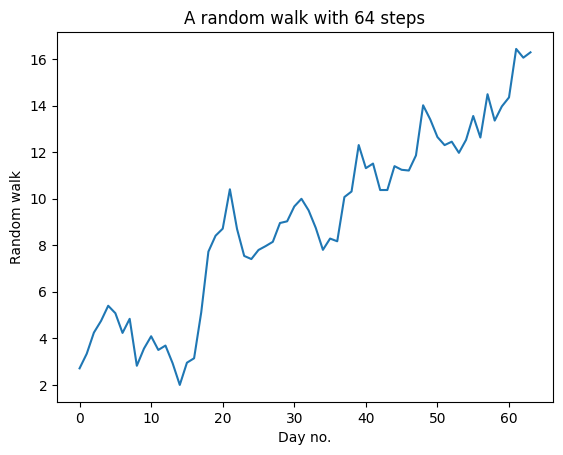

In [ ]:
# ACF of a random walk
np.random.seed(101)
RW_eps = np.random.normal(size = (64,))
RW = np.zeros(shape = (64,))
RW[0] = RW_eps[0]
for i in range(1,64):
    RW[i] = RW[i-1]+RW_eps[i]

x_ = np.arange(64)
    
plt.plot(x_, RW)
plt.xlabel("Day no.")
plt.ylabel("Random walk")
plt.title("A random walk with 64 steps")
plt.show()

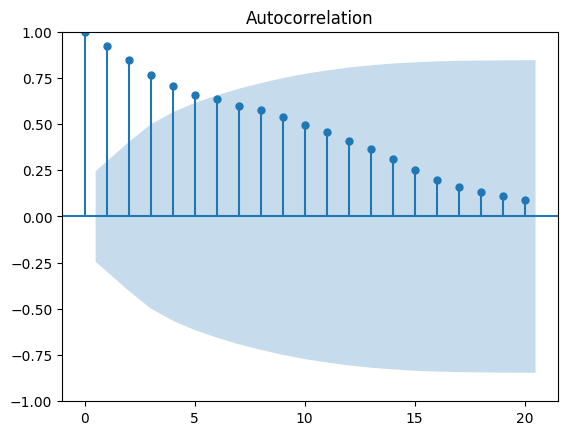

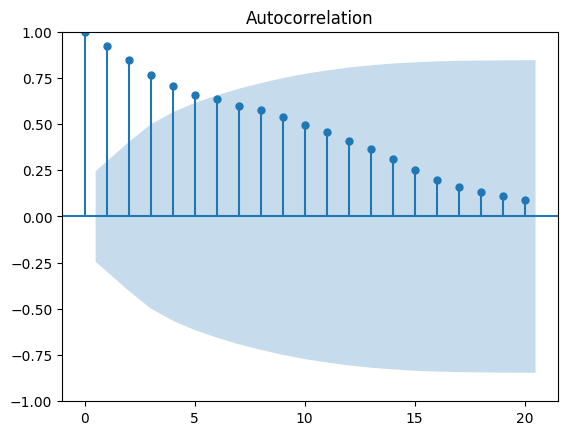

In [ ]:
# ACF plot of the random walk
plot_acf(RW, lags = 20)

Now we apply the Dickey-Fuller test:

In [ ]:
adf_RW, pvalue_RW, lag_RW, _, _, _ = adfuller(RW)
print("Random walk results for ADF test:")
print(f"adf_RW = {adf_RW}, pvalue_RW = {pvalue_RW}, lag_RW = {lag_RW}")

Random walk results for ADF test:
adf_RW = -0.7475116813275955, pvalue_RW = 0.8340562606079737, lag_RW = 0


Let's difference this series now:

In [ ]:
# Differencing n=1 times
diff_RW = np.diff(RW, n=1)

In [ ]:
adf_dRW, pvalue_dRW, lag_dRW, _, _, _ = adfuller(diff_RW)
print("ADF test for random walk differenced once:")
print(f"adf_dRW = {adf_dRW}, pvalue_dRW = {pvalue_dRW}, lag_dRW = {lag_dRW}")

ADF test for random walk differenced once:
adf_dRW = -5.28943604470855, pvalue_dRW = 5.7583988821370726e-06, lag_dRW = 4


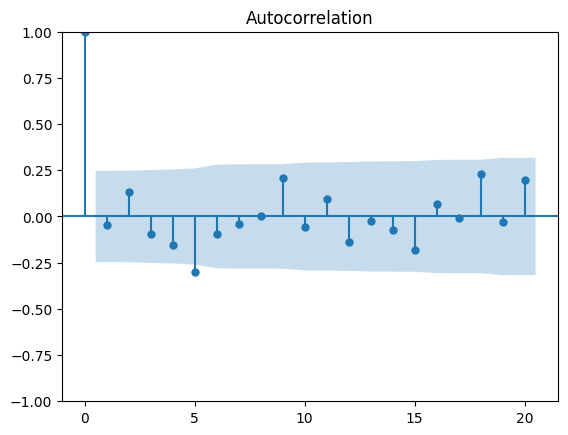

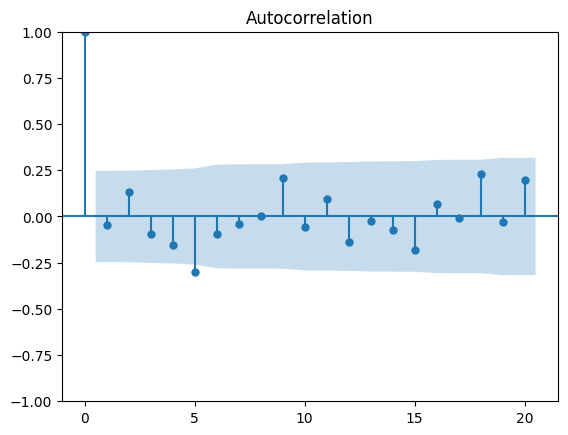

In [ ]:
# ACF plot of the random walk
plot_acf(diff_RW, lags = 20)

**An important conclusion:**
So the random walk is **not stationary**, while its difference is. Indeed, from the equation $y_t = y_{t-1} + \epsilon_t$ used with $\epsilon_t\sim \mathcal{N}(0,1)$, it is obvious that we have a trend in our time series, and the unit root tested for is precisely the coefficient 1 of $y_{t-1}$.
From the ACF plot of the differenced series, we see that the correlations with lags $>0$ are not significant, from which we interpret the series *diff_RW* as having no autocorrelation.

Text(0.5, 1.0, 'Variance plot of a random walk and its differenced process')

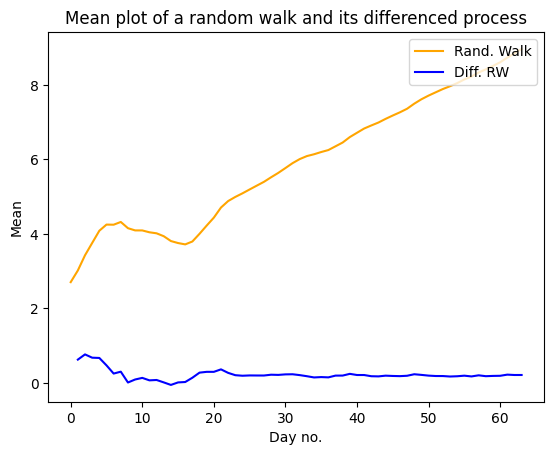

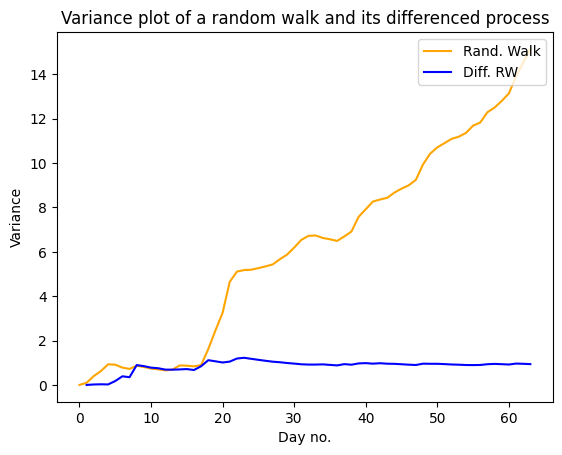

In [ ]:
# Random walk mean and variance
RW_mean = np.empty(shape = (64,))
RW_var = np.empty(shape = (64,))

for i in range(64):
    RW_mean[i] = RW[:i+1].mean()
    RW_var[i] = np.var(RW[:i+1])

# Differenced RW mean and variance
diff_RW_mean = np.empty(shape = (63,))
diff_RW_var = np.empty(shape = (63,))
for i in range(63):
    diff_RW_mean[i] = diff_RW[:i+1].mean()
    diff_RW_var[i] = np.var(diff_RW[:i+1])
    

fig_mean, ax_mean = plt.subplots()
ax_mean.plot(x_, RW_mean, color = 'orange', label = 'Rand. Walk')
ax_mean.plot(x_[1:], diff_RW_mean, color = 'b', label = 'Diff. RW')
ax_mean.legend(loc=1)
ax_mean.set_xlabel("Day no.")
ax_mean.set_ylabel("Mean")
ax_mean.set_title("Mean plot of a random walk and its differenced process")
    
fig_var, ax_var = plt.subplots()
ax_var.plot(x_, RW_var, color = 'orange', label = 'Rand. Walk')
ax_var.plot(x_[1:], diff_RW_var, color = 'b', label = 'Diff. RW')
ax_var.legend(loc=1)
ax_var.set_xlabel("Day no.")
ax_var.set_ylabel("Variance")
ax_var.set_title("Variance plot of a random walk and its differenced process")



### Example 1 - Johnson and Johnson stock price

We'll apply the Dickey-Fuller test to the "JNJ" ticker in our data.

In [ ]:
# Get daily data for JNJ
df_JNJ = df_file[df_file.tic == "JNJ"]

# Feature Engineer params
trade_timeframe = "Day"
trade_ext_hours = True
N_lookback_trade_prds = 1
tech_ind_list = []
use_return_covs = True

# Instantiate feature eng. object
processor = FeatureEngDualTF(tech_indicator_list = tech_ind_list,
                             use_return_covs = use_return_covs,
                             data_source = "Alpaca")


# Preprocess data
data_dict = processor.preprocess_data(df_X = df_JNJ,
                                      trade_timeframe = trade_timeframe,
                                      trade_ext_hours = trade_ext_hours,
                                      N_lookback_trade_prds = N_lookback_trade_prds,)

Chosen data source is Alapaca API. Use set_Alpaca_parameters()
to provide the following parameters:
api_key (str), api_secret (str).
Successfully computed asset returns and their covariances


In [ ]:
# Get DataFrame
df_data = data_dict["df"]

# Build the timestamp list
timestamp_list_ = data_dict["trade_timeframe_info"]["trade_timestamp_list"][:-1]

# Take prices at "16:00"
timestamp_list = [x+" 16:00" for x in timestamp_list_]

# Reduce to daily data
df_data = df_data[df_data.date.isin(timestamp_list)]

# Fix the date entries
df_data.loc[:,"date"] = timestamp_list_

df_data.tail(10)

/tmp/ipykernel_62/3299831623.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.loc[:,"date"] = timestamp_list_


,date,open,high,low,close,volume,tic
3332,2022-10-18,166.40,166.46,166.35,166.44,29679.0,JNJ
3392,2022-10-19,164.44,164.44,164.39,164.40,11189.0,JNJ
3452,2022-10-20,164.75,164.82,164.74,164.82,9587.0,JNJ
3512,2022-10-21,167.81,167.93,167.81,167.90,13779.0,JNJ
3572,2022-10-24,171.64,171.68,171.55,171.64,14747.0,JNJ
3632,2022-10-25,170.24,170.28,170.23,170.28,3624.0,JNJ
3692,2022-10-26,172.16,172.26,172.16,172.25,10024.0,JNJ
3752,2022-10-27,172.83,172.87,172.77,172.85,5656.0,JNJ
3812,2022-10-28,174.52,174.52,174.41,174.42,6419.0,JNJ
3872,2022-10-31,173.90,173.90,173.78,173.78,7135.0,JNJ


In [ ]:
# Get close prices as np.ndarray
JNJ_close = df_data["close"].to_numpy()

Here's what our time series looks like:

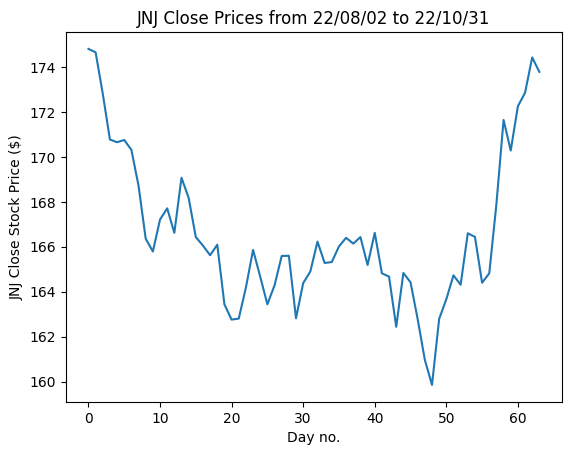

In [ ]:
# x-axis values
x_ = np.arange(len(JNJ_close))
plt.plot(x_, JNJ_close)
plt.xlabel("Day no.")
plt.ylabel("JNJ Close Stock Price ($)")
plt.title("JNJ Close Prices from 22/08/02 to 22/10/31")
plt.show()

And here are the returns

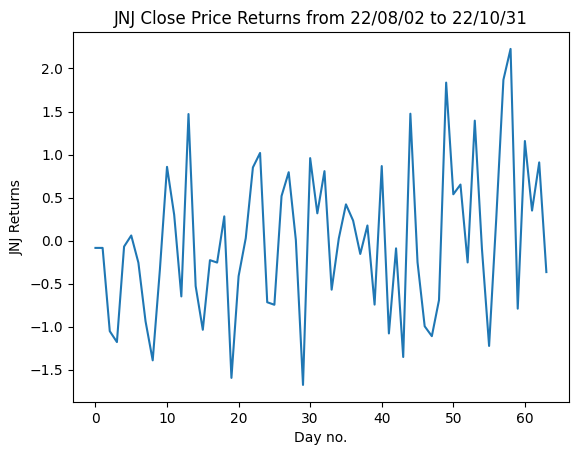

In [ ]:
# Returns
JNJ_Ret = np.empty(shape = (len(JNJ_close),))

JNJ_Ret[1:] = 100.0*((JNJ_close[1:]-JNJ_close[:-1])/JNJ_close[:-1])
JNJ_Ret[0] = JNJ_Ret[1]

plt.plot(x_, JNJ_Ret)
plt.xlabel("Day no.")
plt.ylabel("JNJ Returns")
plt.title("JNJ Close Price Returns from 22/08/02 to 22/10/31")
plt.show()

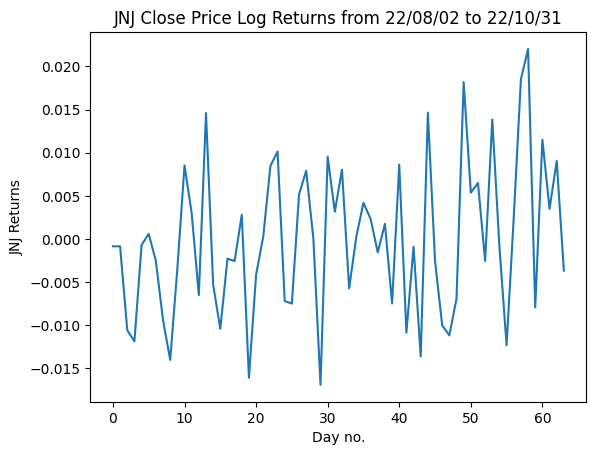

In [ ]:
# Returns
JNJ_LogRet = np.empty(shape = (len(JNJ_close),))

JNJ_LogRet[1:] = np.log(JNJ_close[1:]/JNJ_close[:-1])
JNJ_LogRet[0] = JNJ_LogRet[1]

plt.plot(x_, JNJ_LogRet)
plt.xlabel("Day no.")
plt.ylabel("JNJ Returns")
plt.title("JNJ Close Price Log Returns from 22/08/02 to 22/10/31")
plt.show()

Let's apply the ADF test to the close prices and their returns 




From the *adfuller* help, the returns are as follow:

    Returns
    -------
    adf : float
        The test statistic.
    pvalue : float
        MacKinnon's approximate p-value based on MacKinnon (1994, 2010).
    usedlag : int
        The number of lags used.
    nobs : int
        The number of observations used for the ADF regression and calculation
        of the critical values.
    critical values : dict
        Critical values for the test statistic at the 1 %, 5 %, and 10 %
        levels. Based on MacKinnon (2010).
    icbest : float
        The maximized information criterion if autolag is not None.
    resstore : ResultStore, optional
        A dummy class with results attached as attributes.

In [ ]:
adf_close, pvalue_close, lag_close, _, _, _ = adfuller(JNJ_close)
adf_retns, pvalue_retns, lag_retns, _, _, _ = adfuller(JNJ_Ret)

In [ ]:
print("Close prices results for SDF test:")
print(f"adf_close = {adf_close}, pvalue_close = {pvalue_close}, lag_close = {lag_close}")
print("Close price returns results for SDF test:")
print(f"adf_retns = {adf_retns}, pvalue_retns = {pvalue_retns}, lag_retns = {lag_retns}")

Close prices results for SDF test:
adf_close = -1.3526998641729597, pvalue_close = 0.604730815457107, lag_close = 7
Close price returns results for SDF test:
adf_retns = -2.9413549404170714, pvalue_retns = 0.04074601174181261, lag_retns = 5


According to Peixeiro, when the $p$-value is below 5%, we can consider that the series is stationary. By this criterion, we see from the results above that the close prices are not stationary while their returns are.

**COMMENT:** What is the number of lags returned by the *statsmodels* function *adfuller*?

Now we plot the autocorrelation function for both of our time series:

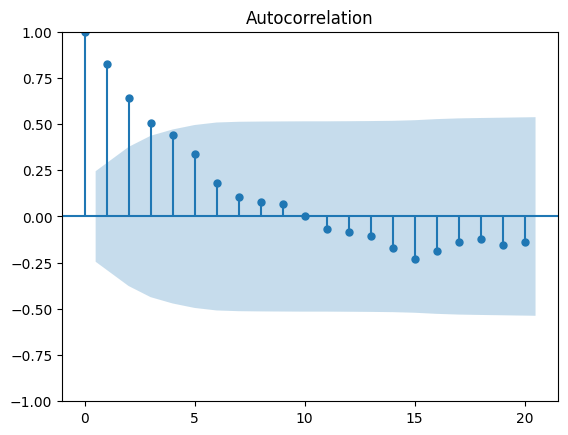

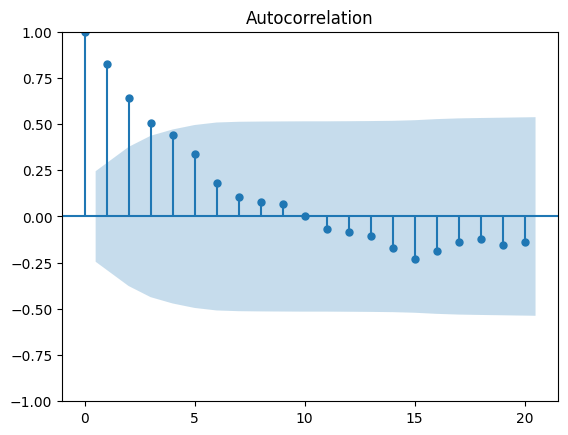

In [ ]:
# Close prices ACF
plot_acf(JNJ_close, lags = 20)

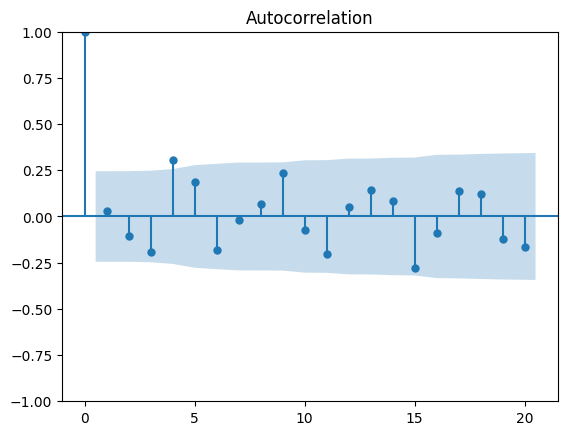

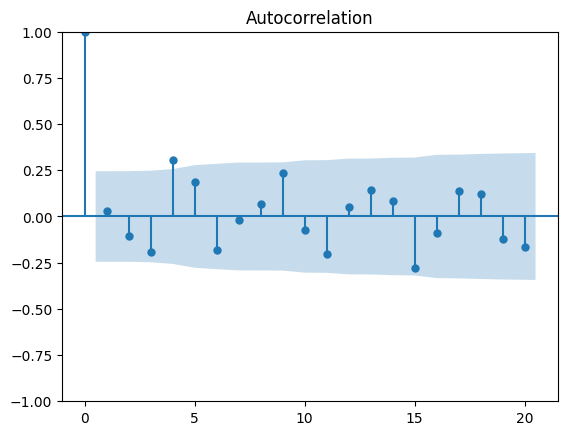

In [ ]:
# Close returns ACF
plot_acf(JNJ_Ret, lags = 20)

**Conclusion:** Following Peixeiro's criteria, we may consider that the log of the close price of JNJ is a random walk, since:
- We can use the returns instead of the log returns;
- The returns show no significant autocorrelation.
- The returns are stationary.

## A.3 - Forecasting a Random Walk (Peixeiro, Sec. 3.3)

For this section, the author looks at 2 possibilities:
- **Forecasting over a long time horizon:** Which he admits is not ideal, and proceeds to discuss 3 possibilities for forecasting a high number of values, namely: (1) Using the mean for the next values; (2) Using the last known value as a prediction for the next values; (3) Interpolating with the series' drift. The 3 approaches yield bad results.
- **Forecasting the next value of the series:** For this part he just uses the last known value as a guess, and the result is just a shifted time series. He briefly discusses the MSE function from *sklearn* as an error measure.

There is not much in section 3.3. I'll move on to Ch.4.

# B) **The Moving Average (MA) Model** (Peixeiro, Ch.4)

So Peixeiro gives the following as an outline for this chapter:
- The definition of an MA model.
- Determining the order of an MA model using autocorrelation.
- Forecasting with an MA model.

This section should mostly be seen as an intro to *statsmodels*.
______________________________________

## B.1 - Definition (Peixeiro, Sec. 4.1)

The object studied in this chapter is the following:

**Definition:** A **moving average** model of **order** $q$  is a time series of the form:

$$y_t = \mu + \epsilon_t +\sum_{i=1}^q\theta_i\epsilon_{t-i}, \forall t>= q,$$

where the $\{\theta_i\}_{i=1}^q$ are the parameters of the $MA(q)$ model, and where $\epsilon_t\sim\mathcal{N}(0,1)$.

First, we note that an $MA(q)$ model must be stationary. At least for the first 2 moments, they're easily shown to be time independent:

$$\mathbb{E}[y_t]=\mu; \ \ \mathrm{Var}[y_t] = 1 + \sum_{i=1}^q\theta_i^2.$$

As usual then, when we will attempt to fit a time series to an $MA(q)$ model, we will have to:
1) First transform the series $\{y_t\}$ to obtain a stationary series $\{\tilde{y}_t\}$.
2) Determine the order $q$ of the moving average model.
______________________________________

## B.2 - Identifying the order of an $MA(q)$ process (Peixeiro, Sec. 4.1.1)

As one would expect, the autocorrelation function is the first tool for finding the order $q$. The recipe is as follows:

**For an $MA(q)$ model, the ACF plot displays significant correlations for lags $1$ to $q$, then an abrupt change in correlation after lag $q$, where all lags $>q$ are not significant.**

Visually, the "non-significant" region is the shaded one shown in the output of *statsmodels'* *plot_acf* function. In the JNJ stock price example.

**An important question:** It would be useful to automate this process of finding the order of the model. Is there an easy way to do this using *statsmodels*? Maybe using the function that computes the ACF:

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html.
_______________________________________

## B.3 - Forecasting with an $MA(q)$ model (Peixeiro, Sec. 4.2)

We finally get to the important part:
- Which submodule of *statsmodels* is used to model an MA process;
- How we fit an $MA(q)$ model to a time series;
- The complexities of making several forecasts.

In Peixeiro's book, his function for rolling forecasts is given in Listing 4.1 on page 72. The corresponding notebook can be found here:

https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH04/CH04.ipynb

Statsmodels have the following tutorial on forecasting:

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html.

Instead of simply reproducing Peixero's examples, we will go into a deeper intro to *statsmodels* in the next section.

_____________________________________________________

## B.4 - Models in the *statsmodels* package

Before moving-on, it will be useful to discuss some specifics of the models offered by the *statsmodels* package. For now, I will focus on the ARMA-related submodules. In particular we look at the *arma_process* and *ARIMA* submodules of *statsmodels.tsa*, and we will discuss the following topics:

* (a) Generating synthetic data using a prescribed (AR)MA model.
* (b) Fitting a time series to a prescribed (AR)MA model.
* (c) Forecasting/predicting a model.

For the sake of continuity and clarity, we will study one example, which will be an $MA(3)$ model with parameters:

$$\theta_1 = -0.85, \theta_2 = 0.75, \theta_1 = -0.25, \mu = 1.5.$$

**Comment:** I'm taking coefficients $|\theta_i|<1$ because otherwise the fitting doesn't work for some reason. For completeness, I am also considering a constant trend $\mu$.

### 4.a - Generating synthetic data

The documentation provides the following example:

https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_1.html

What we use here is found in the submodule *statsmodels.tsa.arima_process*. There are two ways of generating a synthetic time series:
1) Either use the function *arma_generate_sample* as in the link above.
2) Either by first instantiating an *ArmaProcess* object.

We will illustrate with (2). This approach is better, because *arma_generate_sample* requires the AR parameters, which we don't need for now. The documentation for *ArmaProcess* can be found here:

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.html.

Here are the imports needed.

In [ ]:
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess

Next, we use our coefficients to instantiate a model, generate a sample (under the fixed 101 seed), and we plot the beginning 25% of our time series.

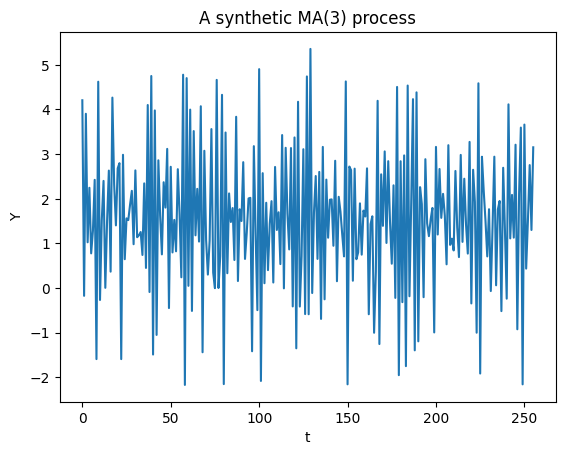

In [ ]:
# Parameters
mu = 1.5
ma_coeffs = [1.0, -0.85, 0.75, -0.25] # statsmodels requires the \theta_0 = 1 parameter
N_obs = 1024
np.random.seed(101)

# Instantiate gen.
MA_generator = ArmaProcess(ar = [1.0,0.0,0.0],#ar = None, #Original
                           ma = ma_coeffs,
                           nobs = N_obs*2)

# Sample 1024 points
Y = MA_generator.generate_sample(N_obs) 
Y = Y+mu

# Plot the first 256 terms of the time series
n_pts = 256
plt.plot(np.arange(n_pts), Y[:n_pts])
plt.xlabel("t")
plt.ylabel("Y")
plt.title("A synthetic MA(3) process")
plt.show()

We can now look at the elementary properties of this model. The *ArmaProcess* class has several useful attributes:

In [ ]:
print(f"Stationarity: MA_generator.isstationary = {MA_generator.isstationary}")
print(f"Invertibility: MA_generator.isinvertible = {MA_generator.isinvertible}")

Stationarity: MA_generator.isstationary = True
Invertibility: MA_generator.isinvertible = True


Next, let's plot the ACF and check the output of the ADF test:

ADF statistic for Y = -15.922913717837286; p-value = 7.886466411174333e-29; No. lags = 5


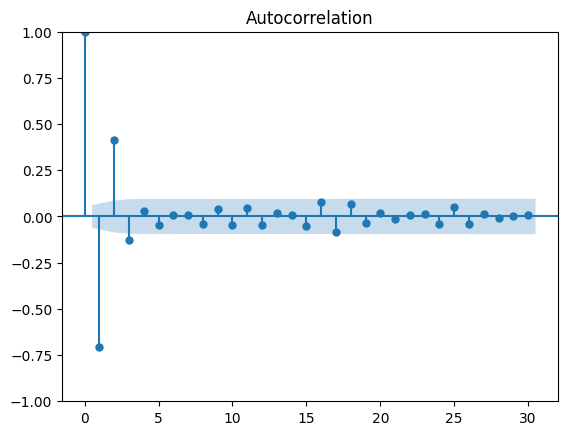

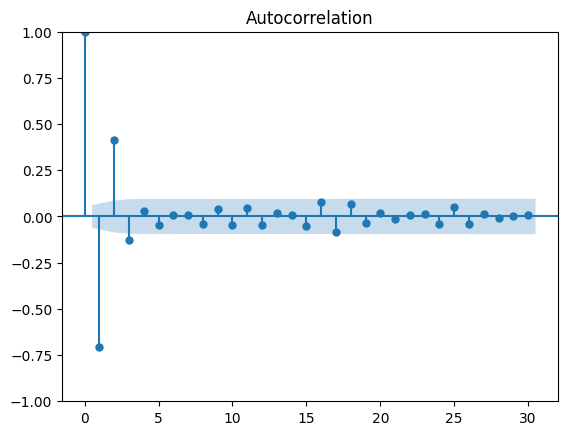

In [ ]:
# Dickey-Fuller
Y_adf, Y_pval, Y_n_lags, _, _, _ = adfuller(Y)
print(f"ADF statistic for Y = {Y_adf}; p-value = {Y_pval}; No. lags = {Y_n_lags}")

# ACF plot
plot_acf(Y, lags = 30)

Notice how the 3rd lag is barely out of the significance region.

**Comment:** If we try this again with an $MA(5)$ process, the ACF plot could be misleading. This is related to the parameters of the model. Here's an example where the ACF plot test does not really work.

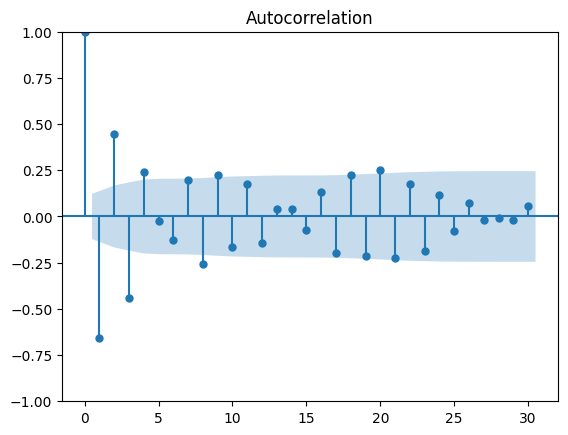

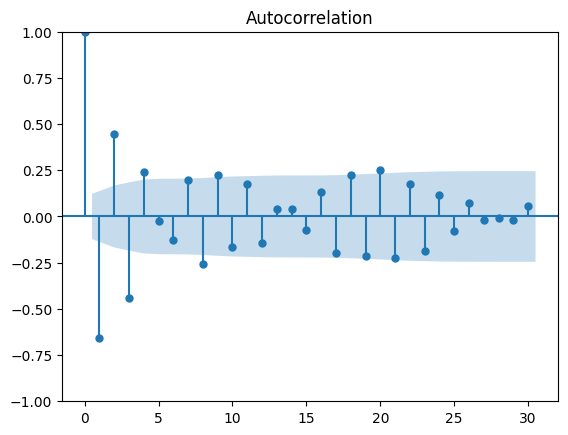

In [ ]:
# Parameters
mu5 = 0.0
ma5_coeffs = [1.0,-0.5, 0.25,-0.85,0.75, -0.3] # statsmodels requires the \theta_0 = 1 parameter
N_obs = 256
np.random.seed(101)

# Instantiate gen.
MA5_generator = ArmaProcess(ar = None, 
                           ma = ma5_coeffs,
                           nobs = N_obs*2)

# Sample 1024 points
Y5 = MA5_generator.generate_sample(N_obs) 
Y5 = Y5+mu5
'''
# Plot the first 256 terms of the time series
n_pts = 256
plt.plot(np.arange(n_pts), Y[:n_pts])
plt.xlabel("t")
plt.ylabel("Y")
plt.title("A synthetic MA(3) process")
plt.show()
'''
# ACF plot
plot_acf(Y5, lags = 30)

### 4.b - Fitting a time series to an ARIMA model

To fit our time series to an ARIMA model, we instantiate an ARIMA object with prescribed parameters and call its *fit()* method. The peculiarity of *statsmodels* is that *fit()* outputs a results-type object, a certain class that contains the model parameters obtained from the learning, as well as a summary of the learning. 

Peixeiro uses a SARIMAX object instead of ARIMA. Their use is similar, with the main difference being that SARIMAX is part of the state space submodule of *statsmodels.tsa*.

Here is the import:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

Next, we split our series into training and testing, where we'll test over 128 points:

In [ ]:
# Data split
n_pts= 128
Y_train = Y[:-n_pts] 
Y_test = Y[-n_pts:]

Now the fitting is done as follows, and we can view the results using a *summary()*:

In [ ]:
# Instantiate the ARIMA object
ARIMA_model = ARIMA(endog = Y_train,
                  order=(0, 0, 3), 
                  trend = 'c')
ARIMA_fit_results = ARIMA_model.fit()
print(ARIMA_fit_results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  896
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -1311.975
Date:                Thu, 25 May 2023   AIC                           2633.951
Time:                        01:53:17   BIC                           2657.940
Sample:                             0   HQIC                          2643.117
                                - 896                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5145      0.022     69.841      0.000       1.472       1.557
ma.L1         -0.8571      0.031    -27.318      0.000      -0.919      -0.796
ma.L2          0.7601      0.034     22.582      0.0

In this specific case, our results are respectbly close to our prescribed parameters:

$$\theta_1 = -0.85, \theta_2 = 0.75, \theta_1 = -0.25, \mu = 1.5.$$

These can be recovered from the results object, whose documentation is here:

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels.tsa.arima.model.ARIMAResults

In particular, if we want the MA coefficients and the coefficient of the fitted trend polynomial:


In [ ]:
print(f"ARIMA_fit_results.maparams = {ARIMA_fit_results.maparams}")
print(f"ARIMA_fit_results.polynomial_trend = {ARIMA_fit_results.polynomial_trend}")
print(f"Since the trend is const: mu = Y_train.mean() = {Y_train.mean()}")

ARIMA_fit_results.maparams = [-0.85706277  0.76007712 -0.28448976]
ARIMA_fit_results.polynomial_trend = []
Since the trend is const: mu = Y_train.mean() = 1.5154953486906895


**Comment:** This is again a question of the parameters of the model. Returning to our "bad" $MA(5)$, the fitting is quite less accurate:

In [ ]:
# Instantiate the ARIMA object
ARIMA_model_2 = ARIMA(endog = Y5,
                  order=(0, 0, 5), 
                  trend = 'c')
ARIMA_fit_results_2 = ARIMA_model_2.fit()
print(ARIMA_fit_results_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  256
Model:                 ARIMA(0, 0, 5)   Log Likelihood                -378.030
Date:                Wed, 24 May 2023   AIC                            770.061
Time:                        17:53:25   BIC                            794.877
Sample:                             0   HQIC                           780.042
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0143      0.015      0.954      0.340      -0.015       0.044
ma.L1         -0.6027      0.065     -9.282      0.000      -0.730      -0.475
ma.L2          0.2314      0.059      3.941      0.0

Compare the "coef" column with our input parameters:

        ma5_coeffs = [-0.5, 0.25, -0.85, 0.75, -0.3], mu5 = 0.0
The results are much worse when $|\theta_i|>1$.
        

### 4.c - Forecasting with an ARIMA model

Now for forecasting, the example provided by the documentation uses a SARIMAX object:

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html.

When it comes to forecasting with an ARIMA model from *statsmodels*, this is done using the *ARIMAResults* object obtained from the fitting. The confusing point here is that this object has 5 methods related to predictions:
* *forecast()*: Out-of-sample forecasts, which outputs an np.ndarray or pd.DataFrame.
* *get_forecast()*: Out-of-sample forecasts and prediction intervals.
* *predict()*: In-sample predictions and out-of sample forecasts. Outputs a *PredictionResults* object.
* *get_prediction()*: In-sample predictions and out-of sample forecasts, as well as confidence intervals. Outputs a *PredictionResults* object.Outputs a *PredictionResults* object.
* *simulate()*: Simulate a new time series following the state space model (verbatim).

More details can be found at:
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels.tsa.arima.model.ARIMAResults

* https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.PredictionResults.html

For later, it's worth noting that *simulate()* could be useful in model-based reinforcement learning.

#### *forecast()*

Documentation: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.forecast.html#statsmodels.tsa.arima.model.ARIMAResults.forecast

This function does out of sample prediction and returns an array whose length is equal to the number of steps in the input. A naive test gives constant forecasts after the order of the MA process:

In [ ]:
# Make forecasts
Y_pred = ARIMA_fit_results.forecast(steps = n_pts)

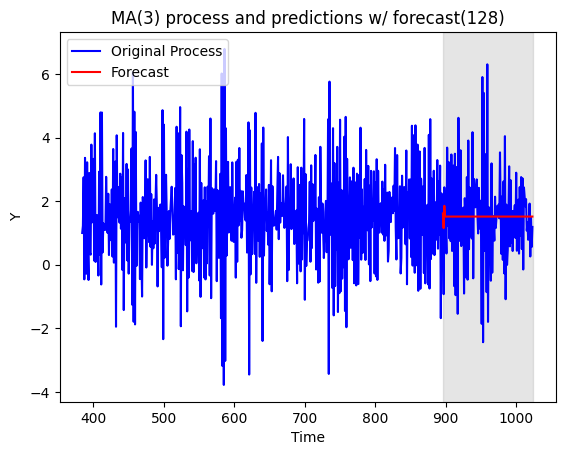

MSE over first 128 points of Y_test and Y_pred:
MSE(Y_pred[:128],Y_test[:128]) = 2.2005584538332723


In [ ]:
# Plot forecasts
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 512,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = n_pts,
               fig_title = 'MA(3) process and predictions w/ forecast(128)',
               legend_loc = 2,
               x_label = 'Time',
               y_label = 'Y',
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

Text(0.5, 1.0, 'MA(5) process and predictions w/ forecast(128)')

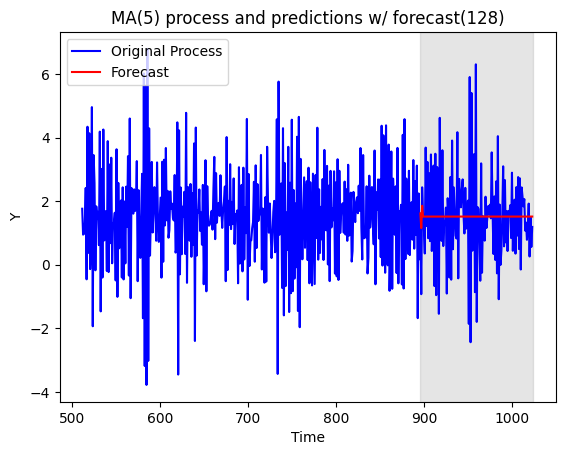

In [ ]:
# Plot (OLD)
x_ = np.arange(512,1024)
x_pred = np.arange(1024-n_pts,1024)
fig_frcst, ax_frcst = plt.subplots()
ax_frcst.plot(x_, Y[512:], color = 'b', label = 'Original Process')
ax_frcst.plot(x_pred, Y_pred, color = 'r', label = 'Forecast')
ax_frcst.legend(loc=2)
ax_frcst.set_xlabel("Time")
ax_frcst.axvspan(1024-n_pts, 1024, color='#808080', alpha=0.2)
ax_frcst.set_ylabel("Y")
ax_frcst.set_title("MA(3) process and predictions w/ forecast(128)")

We will therefore write a rolling forecast function, which will forecast only one future ahead, and then append a new value from the true dataset at each step.

In [ ]:
from copy import deepcopy

def ARIMA_rolling_forecast(trained_model, new_data, n_forecast_pts):
    '''
        Rolling forecast function for a trained statsmodels ARIMA model.
        Calls the following methods of the ARIMAResults class:
        - forecast(): https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.forecast.html#statsmodels.tsa.arima.model.ARIMAResults.forecast
        - append(): https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.append.html#statsmodels.tsa.arima.model.ARIMAResults.append
        - 
        
        :param trained_model: ARIMAResults object corresp. to fitted ARIMA model from which
                            to extract forecasts
        :param new_data: np.ndarray of test data
        :param n_forecast_pts: int, no. of points to forecast out-of-sample.
        
        :return Y_pred: np.ndarray of forecast values
        :return updated_trained_model: ARIMAResults object with appended new_data
        :return MSE_pred: Mean squared error of 
    '''
    if n_forecast_pts>len(new_data)+1:
        raise ValueError("Choose a lower n_forecast_pts param")
        
    # Init. updated trained model
    updated_trained_model = deepcopy(trained_model)
    
    # Init. forecasts array
    Y_pred = np.zeros(shape = (n_pts))
    errors = np.zeros(shape = (n_pts))
    
    # Main loop
    for i in range(n_forecast_pts):
        # Predict new value
        Y_pred[i] = updated_trained_model.forecast(steps = 1)
        # Update the trained model. Passing as a 1-elt list so that len() != None
        updated_trained_model = updated_trained_model.append(endog = [new_data[i]])
        #print(i)
        # Get error
        errors[i] = (Y_pred[i]-new_data[i])**2
        
    # Get predictions MSE
    MSE_pred = errors.mean()
    
    return Y_pred, updated_trained_model, MSE_pred
    

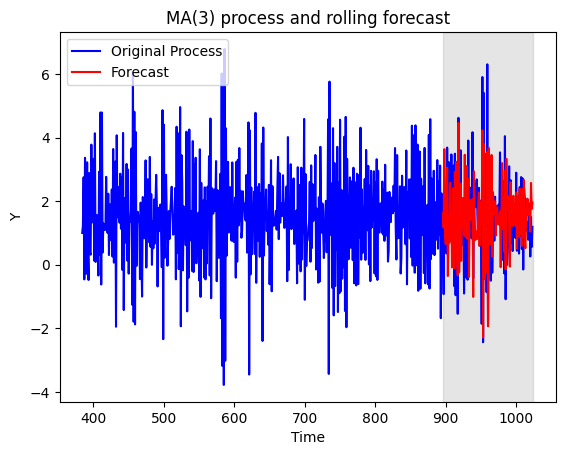

MSE over first 128 points of Y_test and Y_pred:
MSE(Y_pred[:128],Y_test[:128]) = 1.0796610945956002
ARIMA_rolling_forecast output: MSE_pred = 1.0796610945956002


In [ ]:
# Fix no. of future forecast points
n_pts = 128

# Execute rolling forecast
Y_pred, new_ARIMA_fit_results, MSE_pred = ARIMA_rolling_forecast(trained_model = ARIMA_fit_results, 
                                                                 new_data = Y_test, 
                                                                 n_forecast_pts=n_pts)
# Plot forecasts
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 512,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = n_pts,
               fig_title = 'MA(3) process and rolling forecast',
               legend_loc = 2,
               x_label = 'Time',
               y_label = 'Y',
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

print(f"ARIMA_rolling_forecast output: MSE_pred = {MSE_pred}")

ARIMA predictions MSE: MSE_pred = 0.5796919614917896


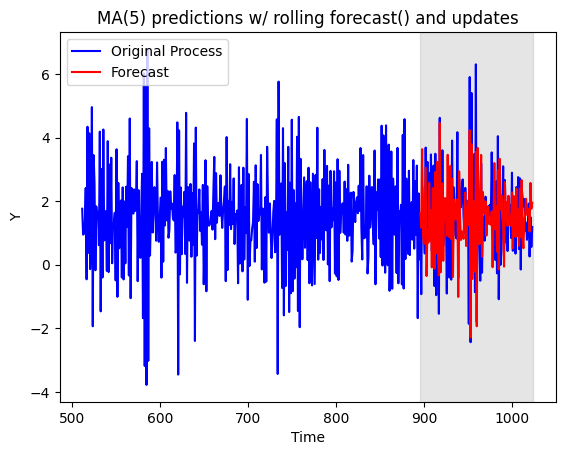

In [ ]:
# Plot (OLD)
x_ = np.arange(512,1024)
x_pred = np.arange(1024-n_pts,1024)

fig_frcst, ax_frcst = plt.subplots()
ax_frcst.plot(x_, Y[512:], color = 'b', label = 'Original Process')
ax_frcst.plot(x_pred, Y_pred, color = 'r', label = 'Forecast')
ax_frcst.legend(loc=2)
ax_frcst.set_xlabel("Time")
ax_frcst.axvspan(1024-n_pts, 1024, color='#808080', alpha=0.2)
ax_frcst.set_ylabel("Y")
ax_frcst.set_title("MA(5) predictions w/ rolling forecast() and updates")

print(f"ARIMA predictions MSE: MSE_pred = {MSE_pred}")

In [ ]:
'''
fig, ax = plt.subplots()

ax.plot(train.value, 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.savefig('figures/CH03_F15_peixeiro.png', dpi=300)
'''

#### *get_forecast()*

Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.get_forecast.html#statsmodels.tsa.arima.model.ARIMAResults.get_forecast

The output of this function is a *PredictionResults* object:
https://www.statsmodels.org/stable/generated/statsmodels.tsa.base.prediction.PredictionResults.html#statsmodels.tsa.base.prediction.PredictionResults

Let's try get_forecast with a naive execution. 

In [ ]:
# Forecast 128 points and get confidence intervals
print("Assigning:\nARIMA_forecast_res = ARIMA_fit_results.get_forecast(steps = n_pts)\n"\
      "ARIMA_forecast_conf_int = ARIMA_forecast_res.conf_int()"
     )
ARIMA_forecast_res = ARIMA_fit_results.get_forecast(steps = n_pts)
ARIMA_forecast_conf_int = ARIMA_forecast_res.conf_int()
print(f"type(ARIMA_forecast_res.predicted_mean) = {type(ARIMA_forecast_res.predicted_mean)}")
print(f"ARIMA_forecast_res.predicted_mean.shape = {ARIMA_forecast_res.predicted_mean.shape}")
print(f"type(ARIMA_forecast_conf_int) = {type(ARIMA_forecast_conf_int)}")
print(f"ARIMA_forecast_conf_int.shape = {ARIMA_forecast_conf_int.shape}")

# Arrays
Y_pred = ARIMA_forecast_res.predicted_mean
Y_conf_int = ARIMA_forecast_conf_int

Assigning:
ARIMA_forecast_res = ARIMA_fit_results.get_forecast(steps = n_pts)
ARIMA_forecast_conf_int = ARIMA_forecast_res.conf_int()
type(ARIMA_forecast_res.predicted_mean) = <class 'numpy.ndarray'>
ARIMA_forecast_res.predicted_mean.shape = (128,)
type(ARIMA_forecast_conf_int) = <class 'numpy.ndarray'>
ARIMA_forecast_conf_int.shape = (128, 2)


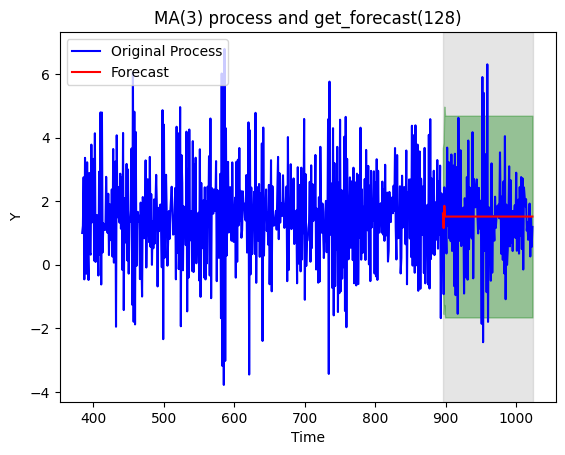

MSE over first 128 points of Y_test and Y_pred:
MSE(Y_pred[:128],Y_test[:128]) = 2.2005584538332723


In [ ]:
# Plot forecasts
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 512,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = n_pts,
               fig_title = 'MA(3) process and get_forecast(128)',
               legend_loc = 2,
               x_label = 'Time',
               y_label = 'Y',
               Y_pred_conf_int = Y_conf_int,
               plot_confidence_band = True,)

Text(0.5, 1.0, 'MA(5) process and get_forecast(128)')

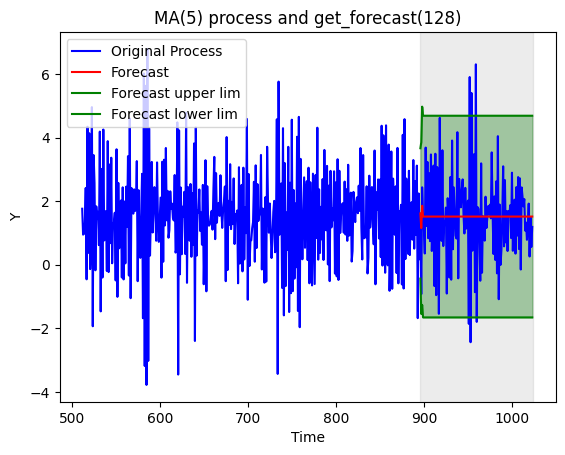

In [ ]:
x_ = np.arange(512,1024)
x_pred = np.arange(1024-n_pts,1024)

fig_frcst, ax_frcst = plt.subplots()
# Original time series
ax_frcst.plot(x_, Y[512:], color = 'b', label = 'Original Process')
# get_forecast() output (Y_gfrcst = PredictionResults.predicted_mean)
ax_frcst.plot(x_pred, Y_gfrcst, color = 'r', label = 'Forecast')
# Upper limit of predictions
ax_frcst.plot(x_pred, ARIMA_forecast_conf_int[:,1], color = 'g', label = 'Forecast upper lim')
# Lower limit of predictions
ax_frcst.plot(x_pred, ARIMA_forecast_conf_int[:,0], color = 'g', label = 'Forecast lower lim')
# Shading of the 95% confidence band
## Ref: https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html
ax_frcst.fill_between(x_pred, ARIMA_forecast_conf_int[:,0], ARIMA_forecast_conf_int[:,1], 
                      color = 'g', alpha=0.35)

ax_frcst.legend(loc=2)
ax_frcst.set_xlabel("Time")
ax_frcst.axvspan(1024-n_pts, 1024, color='#808080', alpha=0.15)
ax_frcst.set_ylabel("Y")
ax_frcst.set_title("MA(5) process and get_forecast(128)")



Now we try again with a rolling forecast:

In [ ]:
def ARIMA_rolling_forecast_conf_int(trained_model, new_data, n_forecast_pts):
    '''
        Rolling forecast function for a trained statsmodels ARIMA model.
        Calls the following methods of the ARIMAResults class:
        - forecast(): https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.forecast.html#statsmodels.tsa.arima.model.ARIMAResults.forecast
        - append(): https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.append.html#statsmodels.tsa.arima.model.ARIMAResults.append
        - 
        
        :param trained_model: ARIMAResults object corresp. to fitted ARIMA model from which
                            to extract forecasts
        :param new_data: np.ndarray of test data
        :param n_forecast_pts: int, no. of points to forecast out-of-sample.
        
        :return Y_pred: np.ndarray of forecast values
        :return updated_trained_model: ARIMAResults object with appended new_data
        :return MSE_pred: Mean squared error of 
    '''
    if n_forecast_pts>len(new_data)+1:
        raise ValueError("Choose a lower n_forecast_pts param")
        
    # Init. updated trained model
    updated_trained_model = deepcopy(trained_model)
    
    # Init. forecasts array
    Y_pred = np.zeros(shape = (n_pts,))
    Y_pred_conf_int = np.zeros(shape = (n_pts,2))
    errors = np.zeros(shape = (n_pts,))
    
    # Main loop
    for i in range(n_forecast_pts):
        # Call get_forecast
        res_temp = updated_trained_model.get_forecast(steps = 1)
        
        # Store new predicted value
        Y_pred[i] = res_temp.predicted_mean
        
        # Store confidence interval
        Y_pred_conf_int[i,:] = res_temp.conf_int()
        
        # Update the trained model. Passing as a 1-elt list so that len() != None
        updated_trained_model = updated_trained_model.append(endog = [new_data[i]])
        #print(i)
        # Get error
        errors[i] = (Y_pred[i]-new_data[i])**2
        
    # Get predictions MSE
    MSE_pred = errors.mean()
    
    return Y_pred, Y_pred_conf_int, updated_trained_model, MSE_pred

In [ ]:
# Forecast and get prediction intervals
Y_pred, Y_pred_conf_int, updated_trained_model, MSE_pred \
        = ARIMA_rolling_forecast_conf_int(trained_model = ARIMA_fit_results, 
                                          new_data = Y_test, 
                                          n_forecast_pts = n_pts)

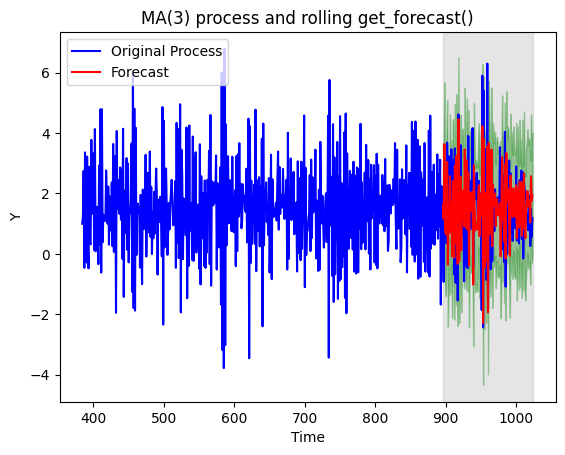

MSE over first 128 points of Y_test and Y_pred:
MSE(Y_pred[:128],Y_test[:128]) = 1.0796610945956002
ARIMA_rolling_forecast output: MSE_pred = 1.0796610945956002


In [ ]:
# Plot forecasts
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 512,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = n_pts,
               fig_title = 'MA(3) process and rolling get_forecast()',
               legend_loc = 2,
               x_label = 'Time',
               y_label = 'Y',
               Y_pred_conf_int = Y_pred_conf_int,
               plot_confidence_band = True,)

print(f"ARIMA_rolling_forecast output: MSE_pred = {MSE_pred}")

#### *predict() and get_predictions()*

**IMPORTANT NOTE: Starting here, this is new material that should be updated in the Paperspace notebook. Also, add *plot_pacf* to the tsatools imports at the beginning of the notebook.** 

Docs: 

* **predict()**: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html#statsmodels.tsa.arima.model.ARIMAResults.predict
* **get_prediction():** https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.get_prediction.html#statsmodels.tsa.arima.model.ARIMAResults.get_prediction


The *predict()* method makes predictions for both the sample dataset and out of it. The documentation describes its two first parameters as:

    start{int, str,datetime}, optional
    Zero-indexed observation number at which to start forecasting, i.e., the first forecast is start. Can also be a date string to parse or a datetime type. Default is the zeroth observation.

    end{int, str,datetime}, optional
    Zero-indexed observation number at which to end forecasting, i.e., the last forecast is end. Can also be a date string to parse or a datetime type. However, if the dates index does not have a fixed frequency, end must be an integer index if you want out of sample prediction. Default is the last observation in the sample.

Just like *forecast()*, the output of this method is an array like object. Note that the *end* parameter of *get_prediction()* is inclusive.

Now turning to *get_prediction()*, the main difference is that it also outputs the confidence intervals.

Let's use it to generate 128 predictions from the end of the sample.

In [ ]:
# Make predictions
Y_pred = ARIMA_fit_results.predict(start = len(Y_train),
                                   end = len(Y_train) + n_pts-1, # Note the -1, because n_pts = end-start +1
                                   )
# Get predictions
ARIMA_pred_res = ARIMA_fit_results.get_prediction(start= len(Y_train),
                                   end = len(Y_train) + n_pts-1,
                                   )
Y_pred_ = ARIMA_pred_res.predicted_mean
Y_pred_conf_int_ = ARIMA_pred_res.conf_int()

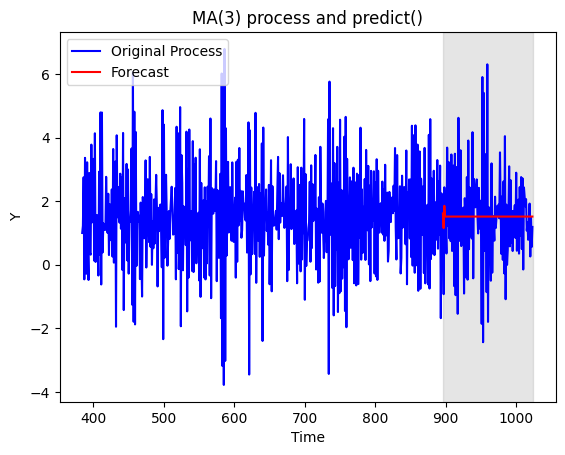

MSE over first 128 points of Y_test and Y_pred:
MSE(Y_pred[:128],Y_test[:128]) = 2.2005584538332723


In [ ]:
# Plot forecasts
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 512,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = n_pts,
               fig_title = 'MA(3) process and predict()',
               legend_loc = 2,
               x_label = 'Time',
               y_label = 'Y',
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

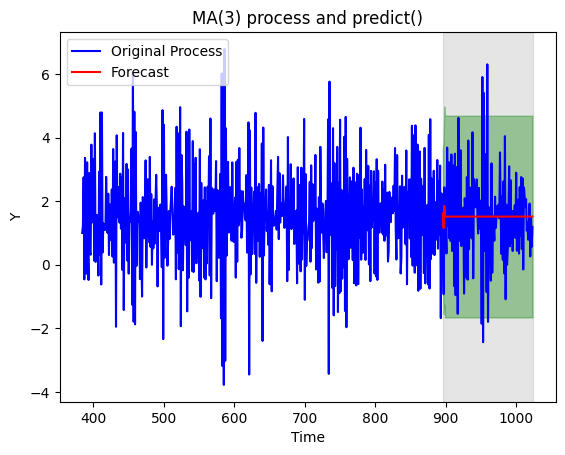

MSE over first 128 points of Y_test and Y_pred:
MSE(Y_pred[:128],Y_test[:128]) = 2.2005584538332723


In [ ]:
# Plot forecasts
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 512,
               Y_test = Y_test,
               Y_pred = Y_pred_,
               n_forecast_plot_pts = n_pts,
               fig_title = 'MA(3) process and predict()',
               legend_loc = 2,
               x_label = 'Time',
               y_label = 'Y',
               Y_pred_conf_int = Y_pred_conf_int_,
               plot_confidence_band = True,)

We expect the same behaviour as previously if we use a rolling forecast, so we skip this part for now.

#### *simulate()*

Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.simulate.html#statsmodels.tsa.arima.model.ARIMAResults.simulate

They don't say much here in the docs. This function is supposed to simulate a new time series following the "state space model". What I'd underline here is the how large the mean squared error of the predictions is compared to the rolling *forecast()* results above. By large I mean about four times larger.

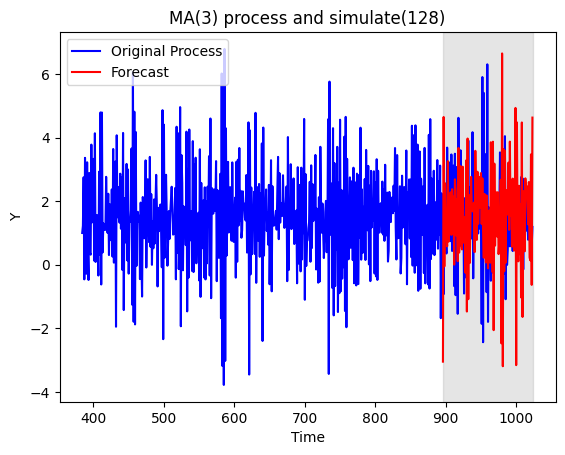

MSE over first 128 points of Y_test and Y_pred:
MSE(Y_pred[:128],Y_test[:128]) = 5.14425667638902


In [ ]:
# Simulate
np.random.seed(101)
Y_sim = ARIMA_fit_results.simulate(nsimulations = n_pts)

# Plot simulation
# Plot forecasts
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 512,
               Y_test = Y_test,
               Y_pred = Y_sim,
               n_forecast_plot_pts = n_pts,
               fig_title = 'MA(3) process and simulate(128)',
               legend_loc = 2,
               x_label = 'Time',
               y_label = 'Y',
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

MSE of simulation: MSE_sim = 5.594535325961084


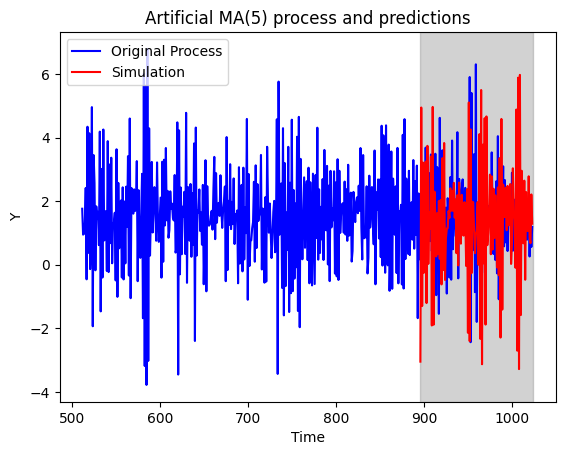

In [ ]:
x_ = np.arange(512,1024)
x_sim = np.arange(1024-n_pts,1024)

fig_frcst, ax_frcst = plt.subplots()
ax_frcst.plot(x_, Y[512:], color = 'b', label = 'Original Process')
ax_frcst.plot(x_sim, Y_sim, color = 'r', label = 'Simulation')
ax_frcst.legend(loc=2)
ax_frcst.set_xlabel("Time")
ax_frcst.axvspan(1024-n_pts, 1024, color='#808080', alpha=0.35)
ax_frcst.set_ylabel("Y")
ax_frcst.set_title("Artificial MA(5) process and predictions")

MSE_sim = ((Y_sim-Y_test)**2).mean()
print(f"MSE of simulation: MSE_sim = {MSE_sim}")

___________________________________________

# C - **The Autoregressive Model (AR)** (Peixeiro Ch.5)

## C.1 - The $AR(p)$ process

**Definition:** An autoregressive process of order $p$ has the form:
$$y_t = \mu + \sum_{i=0}^p\phi_i y_{t-i} + \epsilon_t,\ \ \forall t\in\mathbb{N},$$
where the $\{\phi_i\}_{i=1}^p$ are the autoregressive coefficients.

## C.2 - Determining the order of an $AR(p)$ model

As a first approximation, finding the autoregressive order of a process is done using the PACF:

**Definition:** The partial autocorrelation function (PACF) measures the correlation between two tags $t$ and $t+\tau$, *once we remove the influence of the lags $(t+1), (t+2), \cdots, (t+\tau-1)$*. If after a lag $p$ the partial autocorrelation is not significant, we can assume that the time series has autoregressive order $p$.

A caveat is in order here 

### Example: An $AR(3)$ process

In this part we will simulate an $AR(3)$ process just like we did with the moving average case. This time, we use the parameters:
$$\phi_1 = -0.5, \phi_2 = 0.65, \phi_3 = 0.8, \mu = -2.5.$$

First, we instantiate the model and generate a realization with 1024 timestamps. Note the convention sign for *statsmodels* when inputing the parameters above:

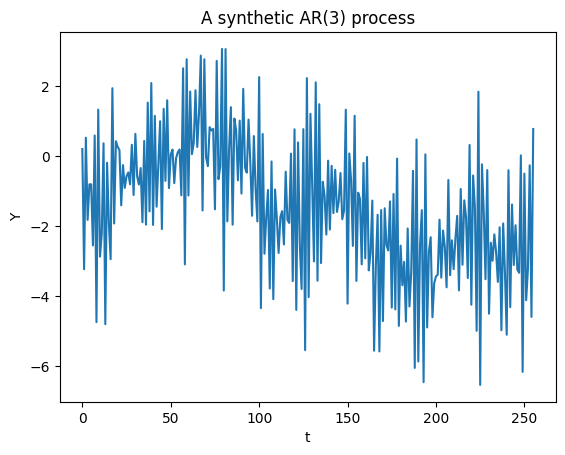

In [3]:
# Model parameters
ar3_mu = -2.5
ar3_coeffs = [1.0, +0.5, -0.65, -0.8] # (phi_1, phi_2, phi_3) = (-0.5, 0.65, 0.8)
ma_coeffs = [1.0,0.0]
N_obs = 1024
np.random.seed(101)

# Instantiate process generator
AR3_generator = ArmaProcess(ar = ar3_coeffs,
                           ma = ma_coeffs,
                           nobs = N_obs*2)

# Sample 1024 points
Y = AR3_generator.generate_sample(N_obs) 
Y = Y+ar3_mu

# Plot the first 256 terms of the time series
plt.plot(np.arange(256), Y[:256])
plt.xlabel("t")
plt.ylabel("Y")
plt.title("A synthetic AR(3) process")
plt.show()

Next, using the ADF test we check the stationarity of the generated time series:

In [4]:
# Perform the ADF test
Y_adf, Y_pval, Y_n_lags, _, _, _ = adfuller(Y)

# Show results:
print("Results of ADF test for AR(3) process:")
print(f"Y_adf = {Y_adf}, Y_pval = {Y_pval}, Y_n_lags = {Y_n_lags}")

Results of ADF test for AR(3) process:
Y_adf = -4.099641837556578, Y_pval = 0.0009698456048208061, Y_n_lags = 2


The autocorrelation function for $Y$ is as follows:

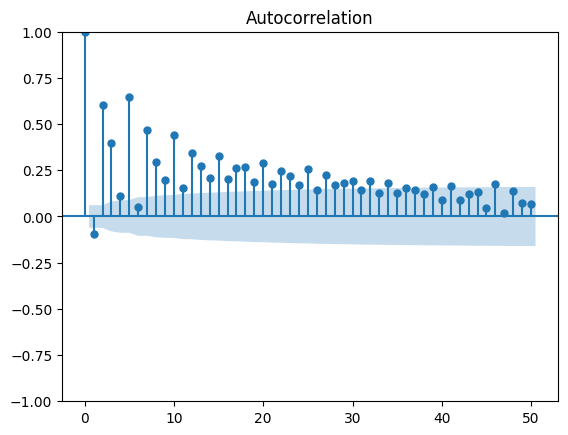

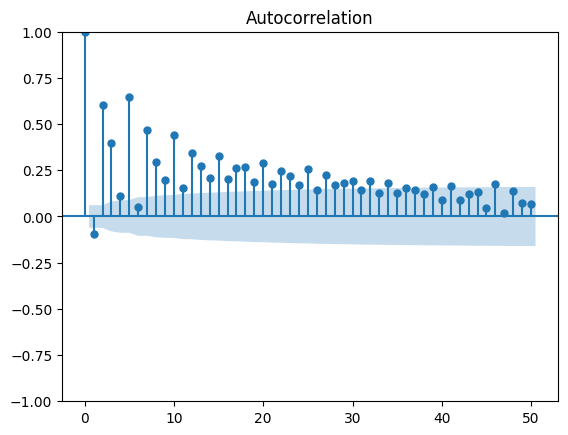

In [6]:
plot_acf(Y, lags = 50)

Notice how many significant lags there are here, as well as their behavior. Unlike the $MA(3)$ case, we see that the significance decay is gradual instead of abrupt, showing that we need another test to identify an appropriate model for $Y$. Plotting the PACF gives us a good estimate this time of $q=3$.

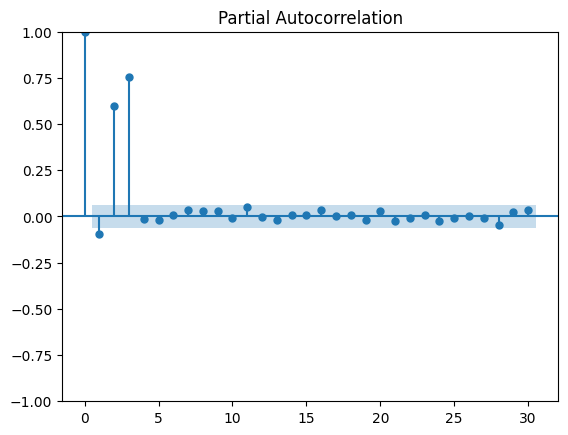

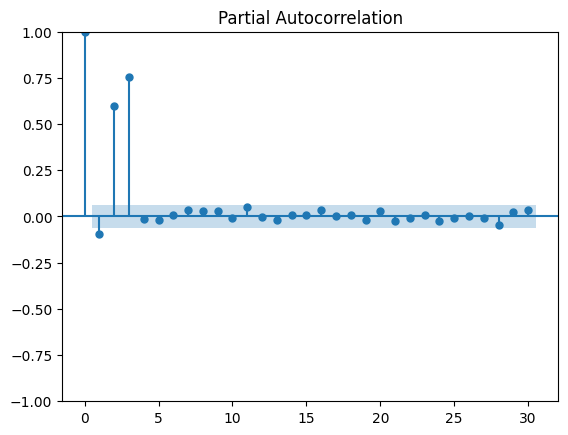

In [8]:
plot_pacf(Y, lags = 30)

The next step is to fit our time series to an ARIMA model:

In [10]:
# Train/test split
n_test_pts = 128
Y_train = Y[:-n_test_pts]
Y_test = Y[-n_test_pts:]

In [11]:
# Instantiate ARIMA object
ARIMA_model = ARIMA(endog = Y_train,
                  order=(3, 0, 0), 
                  trend = 'c')
ARIMA_fit_results = ARIMA_model.fit()
print(ARIMA_fit_results.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  896
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1308.746
Date:                Thu, 25 May 2023   AIC                           2627.492
Time:                        21:35:48   BIC                           2651.482
Sample:                             0   HQIC                          2636.658
                                - 896                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0465      0.318     -6.434      0.000      -2.670      -1.423
ar.L1         -0.4859      0.022    -22.130      0.000      -0.529      -0.443
ar.L2          0.6292      0.017     36.953      0.0

Now we generate 128 forecasts using the results object:

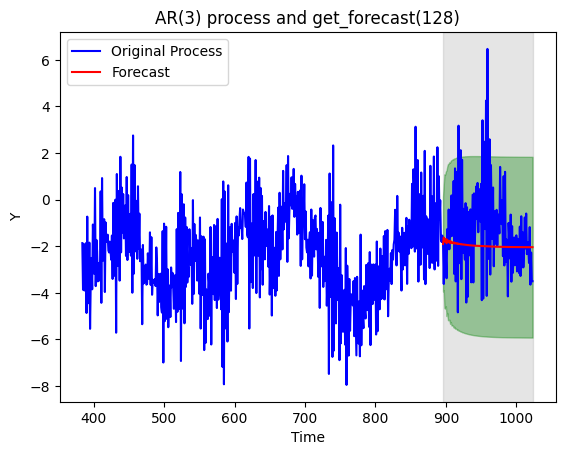

MSE over first 128 points of Y_test and Y_pred:
MSE(Y_pred[:128],Y_test[:128]) = 3.910839124706473


In [14]:
# Make forecasts
n_pts = 128
ARIMA_forecast_res = ARIMA_fit_results.get_forecast(steps = n_pts)
Y_pred = ARIMA_forecast_res.predicted_mean
Y_conf_int = ARIMA_forecast_res.conf_int()

# Plot results
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 512,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = n_pts,
               fig_title = 'AR(3) process and get_forecast(128)',
               legend_loc = 2,
               x_label = 'Time',
               y_label = 'Y',
               Y_pred_conf_int = Y_conf_int,
               plot_confidence_band = True,)

Up to this point, here are the main things to keep in mind:
- Without stationarity, the statistical tests we have been using would be completely invalid. 
- For the ACF, not only is the number of lags important, but so is the rate of significance decay. For the random walk, this decay looked linear. For an MA process, this decay was abrupt after the $q$ order. For an AR process, the decay was particularly slow.
- The PACF gives *some* complementary information on the time series, but up to this point, combining our 3 tests is not enough to identify a general model.
- One should always be aware that the significance region gives 95% probability. This means that 1 time out of 20, we get lags that could be misleading.

In the next section we address more statistical tests for model selection.
_________________________________________________

## C.3 - Addendum: ACF and PACF as correlations

For the sake of comparison, it's useful to express these ideas in formulas at this point. Here, I'll follow Brockwell-Davis' "Introduction to time series and forecasting" (Ch.2 on stationary models and the ACF, Ch.3 on ARMA models).

First, we need to be clear about the fact that we are using **the weak stationarity of time series**. This means that for a fixed process $\{Y_t\}_{t\in\mathbb{N}}$ with $\mathbb{E}[Y^2_t]<\infty$, we are assuming that:

1) Its expectation is constant:
$$\mu_Y(t) : = \mathbb{E}[Y_t] = \mu_Y (const.).$$
(i.e. there's no trend in any realization $\{y_t\}$.)

2) The covariance between two times $0\le s\le t$ is a function of $(t-s)$:
$$\gamma_Y(t,s):=\mathrm{Cov}(Y_t,Y_s) = \gamma_Y(t-s).$$

With this notation and the weak stationarity assumption, the ACF is defined as:
$$\rho_Y(h):=\frac{\gamma_Y(h)}{\gamma{0}}=\frac{\mathrm{Cov}(Y_{t+h},Y_t)}{\sigma_{Y_{t+h}}\sigma_{Y_t}},\ \forall h\in\mathbb{N}.$$
Obviously, when we consider a realization $\{y_t\}$ of this weakly stationary process, we compute the sample ACF in practice:
$$\hat{\rho}(h) = \frac{\hat{\gamma}(h)}{\hat{\gamma}(0)}.$$

In contrast, the PACF is more involved to define. Morally, the PACF at lag $h$ is the correlation between $Y_t$ and $Y_{t+h}$ **conditioned on** $\{Y_{t+j}\}_{j=1}^{h-1}$ (the definition of the PACF in Brockwell-Davis (sec. 3.2.3) comes with no explanation).

In formulae, to define the PACF at lag $h$, we consider estimators $\hat{Y}_t$ and $$\hat{Y}_{t+h}$$ which are **linear in $\{Y_{t+j}\}_{j=1}^{h-1}$**:
$$\hat{Y}_{t+h} = \beta_0 + \beta_1Y_{t+1}+\cdots + \beta_{h-1}Y_{t+h-1},$$
$$\hat{Y}_{t+h} = \beta_0' + \beta_1'Y_{t+1}+\cdots + \beta_{h-1}'Y_{t+h-1},$$
and we set the PACF at lags $h>1$ to be the correlation:
$$\varphi_{h,h}:=\mathrm{Corr}(Y_{t+h}-\hat{Y}_{t+h},Y_t-\hat{Y}_t),$$
and for $h=0,1$:
$$\varphi_{0,0}=\varphi_{1,1} = 1.$$
__________________________________________________________________________

# D - **Statistical Tests for $ARMA(p,q)$ models** (Peixeiro Ch.6)

Now we look at the *stationary* generalization of MA and AR models. The main purpose of this section however are the statistical methods for the identification of such models, namely:
* The Akaike information criterion;
* The Ljung-Box test;
* Residuals analysis.

The notebook containing Peixeiro's examples of Ch.6 can be found here:

https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH06/CH06.ipynb

_________________________________________________________________

## D.1 - The $ARMA(p,q)$ process

As one would expect

**Definition:** An autoregressive moving average process of orders $(p,q)$ has the form:
$$y_t = \mu + \sum_{i=0}^p\phi_i y_{t-i} + \epsilon_t+\sum_{j=1}^q\theta_j \epsilon_{t-j},\ \ \forall t\in\mathbb{N},$$
where the $\{\phi_i\}_{i=1}^p$ are the autoregressive coefficients and $\{\theta_j\}_{j=1}^q$ are the moving average coefficients.

Obviously, $MA(q)=ARMA(0,q)$ and $AR(p)=ARMA(p,0)$. The first thing to know here is that after testing for stationarity, the ACF and PACF **do not** allow us to identify an $ARMA(p,q)$ process in the same way as previously. Peixeiro gives the following clue (p.110):

**If a time series is stationary and both the ACF and PACF plots show a significance decay or a sinusoidal pattern, then the series is a realization of an $ARMA(p,q)$ process.**

Let's illustrate with an example.

### Example 1: An $ARMA(1,1)$ time series

In this example, we will use:
$$\mu=0, \phi_1 = 0.33, \theta_1 = 0.9.$$

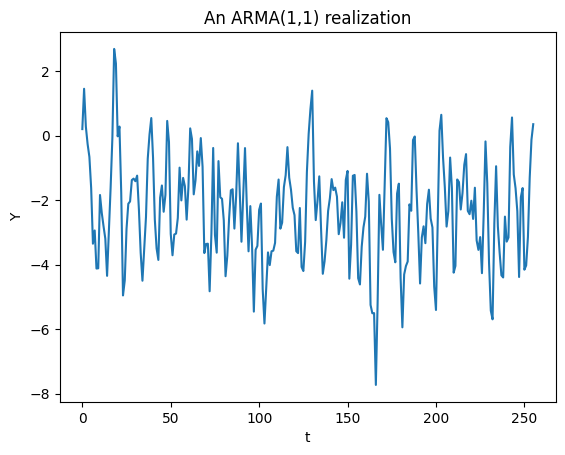

In [16]:
# Model parameters
arma11_mu = 0.0
np.random.seed(101)
N_obs = 1024
ar_coeffs = [1.0, -0.33]
ma_coeffs = [1.0, 0.9]

# Instantiate process generator
ARMA11_generator = ArmaProcess(ar = ar_coeffs,
                               ma = ma_coeffs,
                               nobs = N_obs*2)

# Sample 1024 points
Y = ARMA11_generator.generate_sample(N_obs) 
Y = Y+ar3_mu

# Plot the first 256 terms of the time series
plt.plot(np.arange(256), Y[:256])
plt.xlabel("t")
plt.ylabel("Y")
plt.title("An ARMA(1,1) realization")
plt.show()

The Dickey-Fuller test yields the following

In [17]:
# Perform the ADF test
Y_adf, Y_pval, Y_n_lags, _, _, _ = adfuller(Y)

# Show results:
print("Results of ADF test for AR(3) process:")
print(f"Y_adf = {Y_adf}, Y_pval = {Y_pval}, Y_n_lags = {Y_n_lags}")

Results of ADF test for AR(3) process:
Y_adf = -7.894877815428892, Y_pval = 4.337678517175786e-12, Y_n_lags = 16


Now we plot the ACF and PACF:

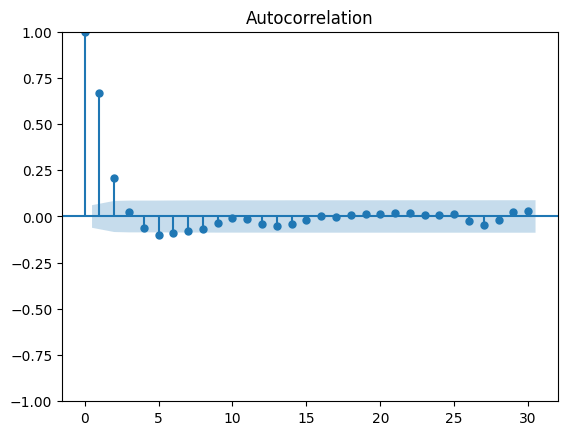

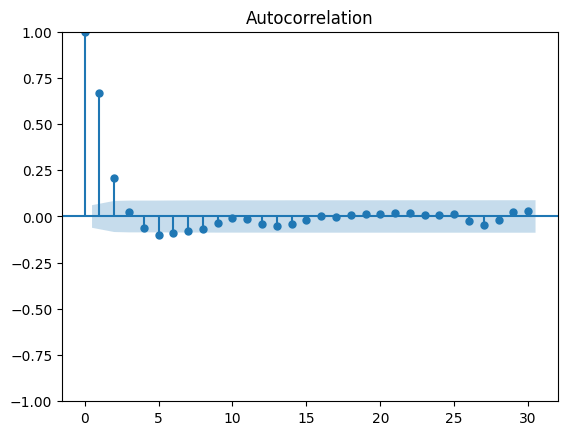

In [19]:
plot_acf(Y, lags = 30)

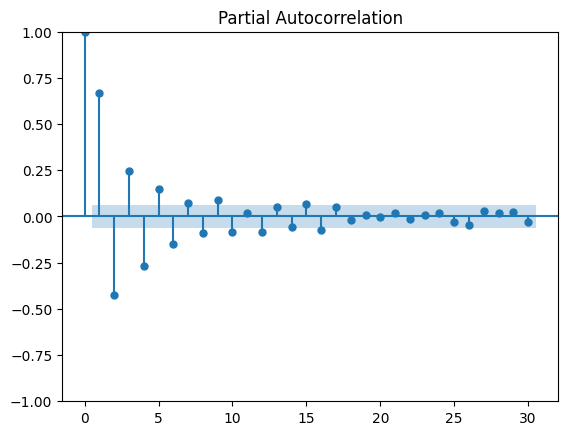

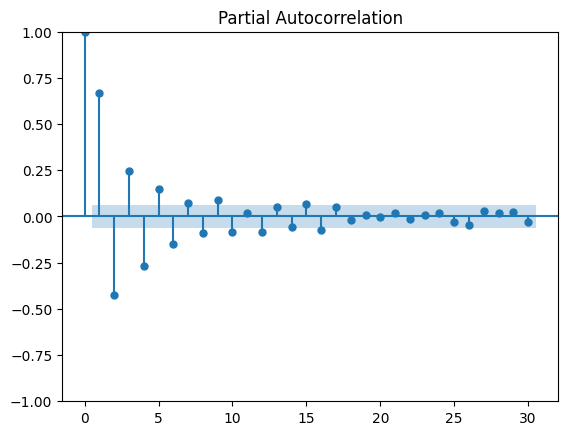

In [20]:
plot_pacf(Y, lags = 30)

Using the previous tests for MA and AR processes, we would conclude that $q=2$ and $p=6$, which is not true obviously. We note however that the ACF displays a quasi-sinusoidal behavior, and a similar albeit faster significance decay in the PACF.

The next subsections of the ARMA part discuss the *Akaike information criterion* and the *Ljung-Box* test. Once these are briefly explained, we will summarize the general procedure for selecting an the appropriate orders $(p,q)$ to model a time series.

____________________________________________________

## D.2 - The Akaike Information Criterion, Quantile-Quantile plots, and the Ljung-Box Test

The brute force way of fitting a time series to an $ARMA(p,q)$ model would be to use a grid search in the parameters $(\phi_i,\theta_j)$, meaning that we'd fit the time series to a list of $(p,q)$ values first and take the one with the least MSE for instance. This is computationally quite costly, and this question has been studied by statisticians quite a bit.

### 2.a) The Akaike information criterion

Suppose $\widehat{L}(\phi,\theta,y)$ denotes the likelihood of a given model, and let $\mathcal{W}=\mathbb{R}^k$ denotes the space of parameters. We have the following definitions:

**Definition:** Let $\{y_t\}_t=0^{T-1}$ be a fixed time series. The Akaike information criterion (AIC) is defined as:
$$AIC(\phi,\theta,y):=2\dim \mathcal{W}-2\ln \widehat{L}.$$
In words, the AIC is the negative log-likelihood penalized by the number of parameters of the model.

It's worth noting here that the actual computation of the likelihood is non-trivial. A Bayesian approach to its computation and to the model fitting questions is discussed in Ch.7 of Box-Jenkins-Reinsel-Ljung. Another approach is to use an approximate Gaussian likelihood, as discussed in sec. 9.2 of Subba Rao's lecture notes (on time series), and which involves Kalman filters.

The AIC is used as the objective function for the selection of an $ARMA(p,q)$ model, where we seek a model that minimizes its value.

In *statsmodels*, if we use an *ARIMA* (or *SARIMAX*) object, we saw that fitting a time series returns a *Results* object. One of the attributes/properties of the latter is the AIC:
* https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels.tsa.arima.model.ARIMAResults.
For illustration, Peixeiro does a grid search in $(p,q)$ to determine an appropriate model for a given time series. He picks the model with the lowest AIC (pp.113-116).

### 2.b) Residuals analysis and Quantile-Quantile plots

**Definition:** Given a statistical model, a residual is the difference between a predicted value and a true observation.

Given a time series $\{y_t\}$, suppose we have found an adequate ARMA model to fit the series, and that we have forecasts $\{\hat{y}_t\}$ of our time series. The residual in this case will be:
$$r_t:=y_t - \hat{y}_t.$$
Ideally, we would like to have $r_t=\epsilon_t\sim\mathcal{N}(0,1)$, i.e. that the model $\hat{y}_t$ captures all the predictive information except for the white noise. We thus need to check that:
1) The residuals at different lags are uncorrelated;
2) The residuals follow a standard Gaussian.

The next step of our procedure is more qualitative. From the above, it is clear that we have to compare the residuals $\{r_t\}$ to a normal distribution. To do this Peixeiro uses so-called **Quantile-Quantile** (QQ-) plots, which plot (along the y-axis) the estimated quantiles of a sample dataset against the quantiles of a theoretical distribution (along x-axis). If the sample dataset was indeed generated by the candidate theoretical distribution, the points of the QQ-plot fall along the $y=x$ axis.

Some starting points to understand this better:
* Q-Q plots: https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot
* Quantiles of a distribution: https://en.wikipedia.org/wiki/Quantile

#### Example of a QQ-plot

To illustrate such plots, we generate a dataset of 1000 normally distributed points and take their square. We then produce the QQ-plot to compare the two samples to a normal distribution. Note that we need to specify *line = "45"* parameter in *statsmodels*' qqplot function to be able to make the desired comparison.


In [1]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm

In [7]:
# Instantiate scipy normal distribution
normal_rv = norm()

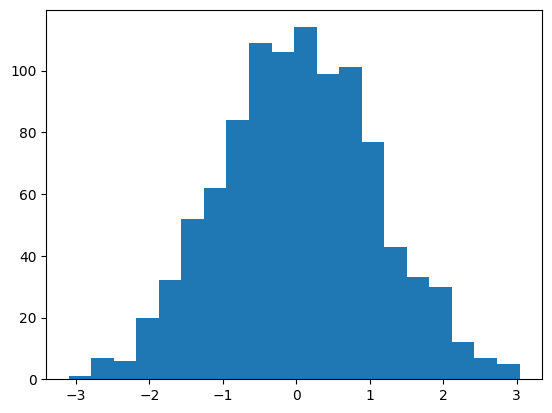

In [5]:
# Generate normally distributed sample
np.random.seed(101)
N_pts = 1000
X = np.random.normal(loc = 0, scale = 1, size = (N_pts,))
X_hist_vals, X_50_bins, _ = plt.hist(X, bins = 20)

For the normally distributed sample, the quantiles lie along the $y=x$ axis:

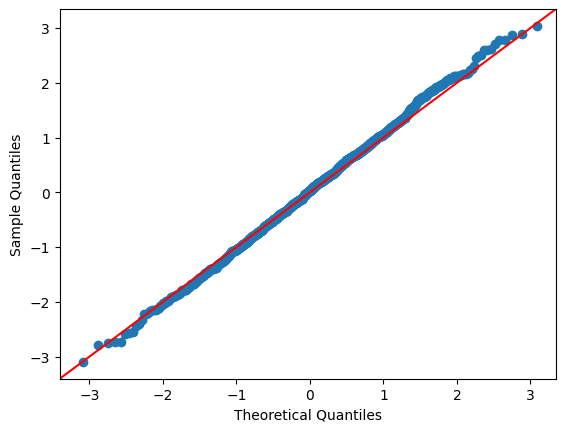

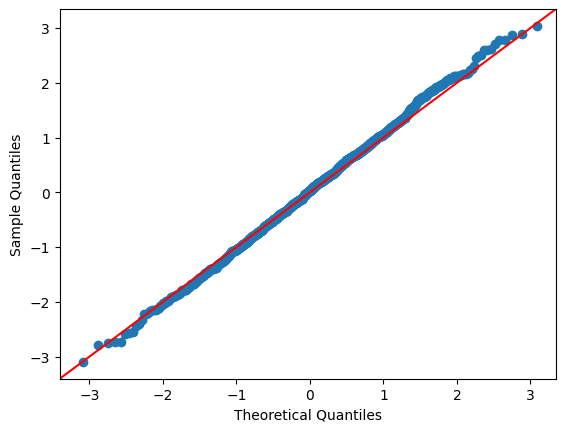

In [8]:
qqplot(data = X, dist=normal_rv, line = "45")

Now we compare the squares to the normal distribution:

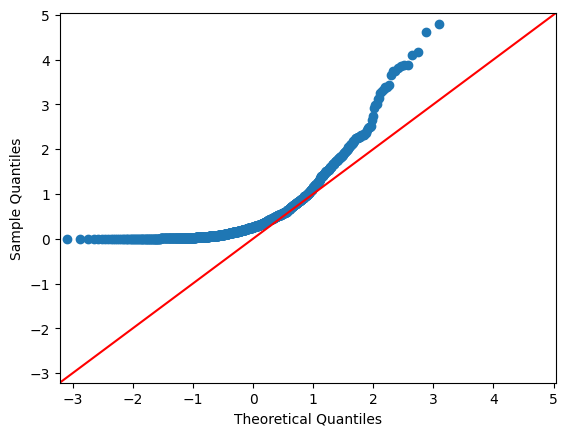

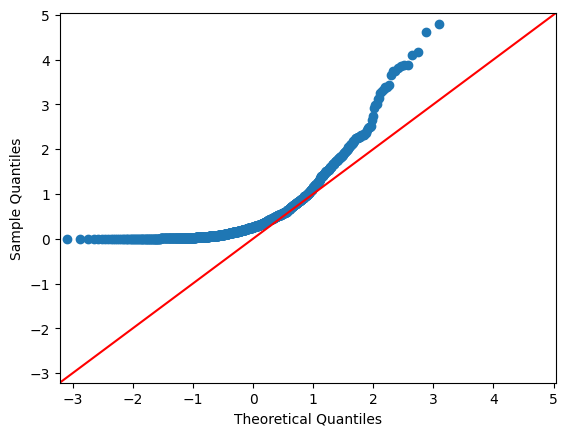

In [9]:
qqplot(data = 0.5*(X**2), dist=normal_rv, line = "45")

This is a qualitative test to get an idea of the distribution of the residuals. I would personnaly use some type of likelihood estimation for comparison, but we'll follow this approach for the purposes of the book. The reason Peixeiro introduces this topic is that the *Results* class od *statmodels* fitting has a method *plot_diagnostics()* which displays the QQ-plot (among others). We will illustrate this below with the main example of this section.

Documentation links:
* Statsmodels QQ-plot: https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html
* Scipy continuous distributions:
    * Intro: https://docs.scipy.org/doc/scipy/tutorial/stats/continuous.html
    * Normal: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
* Diagnostic plots of results: https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html#statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics

### 2.c) Residuals analysis and the Ljung-Box test

After determining that the residuals are normally distributed, we apply a statistical test to determine whether or not said residuals are uncorrelated. This is done using the **Ljung-Box test**. Peixeiro describes it as follows:

**The Ljung-Box test is used to see whether the autocorrelation of a dataset is significantly larger than 0. The null hypothesis of this test is that the datapoints are independently distributed (i.e. no autocorrelation). We assume that the null hypothesis is satisfied if the p-value of the test is larger than 0.05.**

In practice, this test is performed using *statsmodels*' *acorr_ljungbox()* function:

https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html.

One important thing to note about this function, is that its output is dataframe with the LB stat and its p-value. The number of rows of the datad is the number of lags at which the test is applied. This will be more understandable in the example below.

#### **Synthesis: The general modeling procedure**
As Peixeiro presents this, once we answer **yes** to all of the following questions:
1) Is the process stationary (i.e. ADF gives a p-value lower than 0.05)?
2) Have we found orders $(p,q)$ that minimize the AIC?
3) Are the residuals normally distributed (i.e. the QQ-plot displaying points very close to $y=x$)?
4) Are the residuals uncorrelated (i.e. Ljung-Box gives a p-value greater than 0.05)?
then we can consider that our time series can be accurately modelled by an $ARMA(p,q)$ process.

In *statsmodels*, one recovers the residuals of the fitting using the *resid* attribute of the fit *Results* object, see:
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels.tsa.arima.model.ARIMAResults
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.resid.html#statsmodels.tsa.arima.model.ARIMAResults.resid.
__________________________________________________________________________

# E - **Synthesis Example: Forecasting close price returns with $ARIMA(p,d,q)$**

**ARIMA processes:**

As one would expect, the "I" in ARIMA stands for integrated, and the integration degree $d$ is simply the number of times that we have to difference the time series to obtain a stationary time series. As such, if $\{Y_t\}$ is an $ARIMA(p,d,q)$ process, then its second differenced series $\{Y^{(2)}_t\}$ is an $ARMA(p,q)$ process.

In this section we will study the Johnson and Johnson close prices between 2022-08-01 and 2022-10-31. The time series of interest will be the log return series of the close prices, and we will:

1) Test for the stationarity of the log returns time series;
2) Search for an $ARMA(p,q)$ (or $ARIMA(p,d,q)$) process that minimizes the Akaike information criterion;
3) Fit the time series and produce a forecast over 10 days.
4) Use the log returns results to forecast the close prices.

We will do this using 3 approaches:

* First, using simply an $ARMA(p,q)$ model.
* Next, using an $ARIMA(p,d,q)$ model.
* Lastly, using the Python implementation of R's *auto_arima* function.

_________________________________________________________________

## E.0 - Johnson and Johnson close prices and log returns.

Here we load the data from a CSV file and use a helper function that returns the two desired dataframes (daily close price of the stock and corresponding log returns).


In [6]:
# Load DJIA file 
df_Alpaca_15min = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Get close price log returns of JNJ
df_returns, df_close = get_daily_stock_returns(df_data = df_Alpaca_15min,
                                               stock_tickers_list = ["JNJ"],
                                               start_date = "2022-08-01",
                                               end_date = "2022-10-31",
                                               log_returns = True,)


<AxesSubplot: >

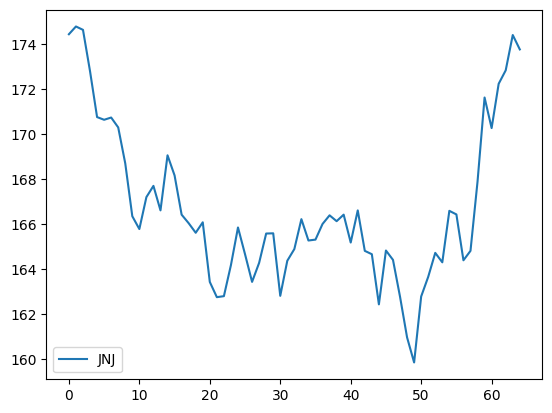

In [7]:
df_close.plot()

<AxesSubplot: >

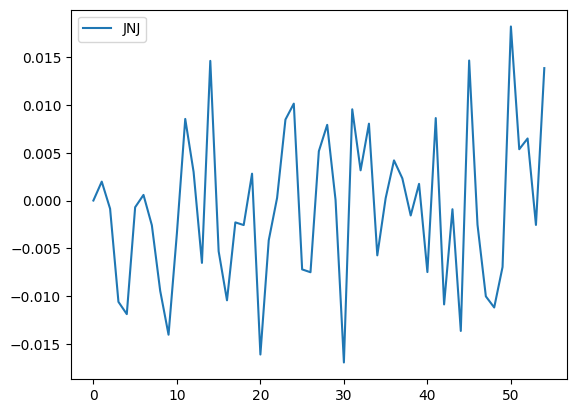

In [8]:
# Get the time series and split into train-test
Y = df_returns["JNJ"].to_numpy()
N_test = 10
Y_train = Y[:-N_test]
Y_test = Y[-N_test:]

# Plot last 20 points of time series
df_returns.iloc[:-N_test].plot()

_________________________________________________________________

## E.1 - Forecasting with an $ARMA(p,q)$ model



### (a) Testing for stationarity

As it happens, the log returns **are not** stationary:

In [9]:
# Execute ADF test
Y_ADF, Y_ADF_pval, Y_n_lags, _, _, _ = adfuller(Y_train)
print("Augmented Dickey-Fuller Test results:")
print(f"Y_ADF = {Y_ADF}, Y_ADF_pval = {Y_ADF_pval}, Y_n_lags = {Y_n_lags}")

Augmented Dickey-Fuller Test results:
Y_ADF = -2.3495379865566526, Y_ADF_pval = 0.15648811194090378, Y_n_lags = 5


We get a stationary series by differencing though:

In [10]:
# Difference the log returns
Z_train = np.diff(Y_train)

# Execute ADF test
Z_ADF, Z_ADF_pval, Z_n_lags, _, _, _ = adfuller(Z_train)
print("Augmented Dickey-Fuller Test results:")
print(f"Z_ADF = {Z_ADF}, Z_ADF_pval = {Z_ADF_pval}, Z_n_lags = {Z_n_lags}")

Augmented Dickey-Fuller Test results:
Z_ADF = -8.472045239685661, Z_ADF_pval = 1.468728707971959e-13, Z_n_lags = 3


Consequently, we will work with the differenced series $\{z_t\}=\{y^{(1)}_t\}$ for the remainder of this subsection. 

### (b) ACF and PACF plots

Now we plot the ACF and PACF of $\{z_t\}$

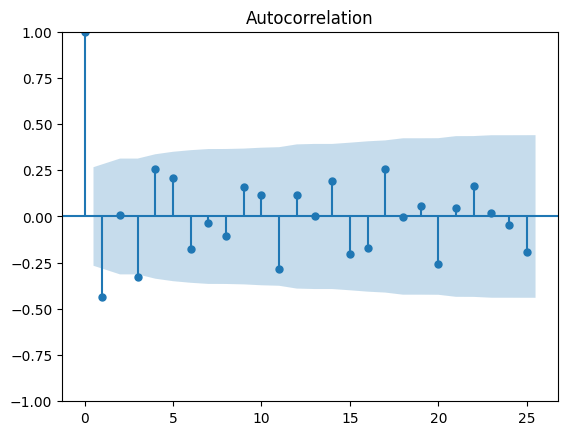

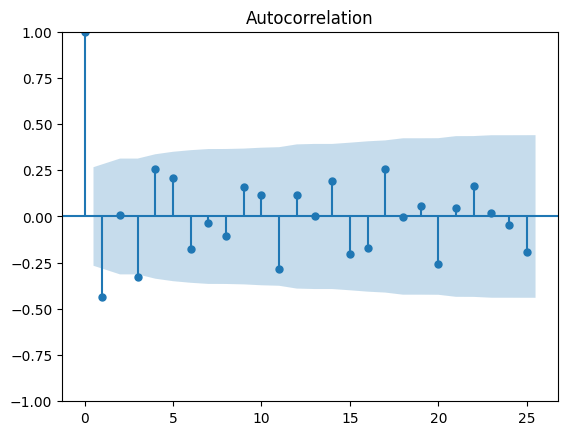

In [12]:
# Plot ACF
plot_acf(x = Z_train, lags = 25)

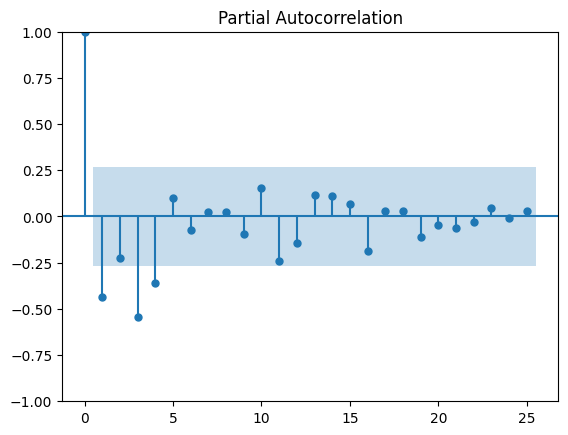

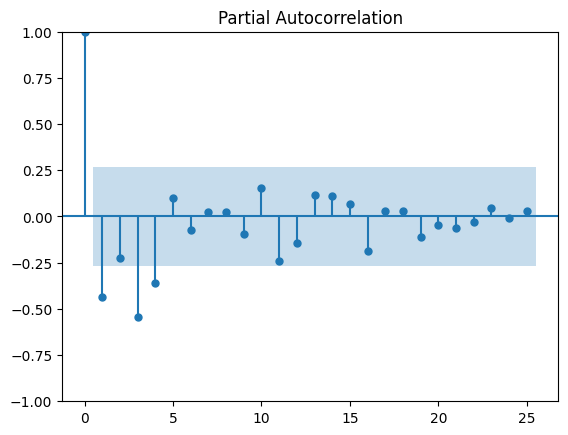

In [13]:
# Plot PACF
plot_pacf(x = Z_train, lags = 25)

We see sinusoidal and slow decay of lag significance here. This tells us that we are very likely dealing with an $ARMA(p,q)$ model.

### (C) Grid search on $(p,q)$ parameters

From the ACF, we expect a **maximal** $q$ of 3, while the PACF suggests that our **maximal** $p$ is 4. A basic grid search yields the following:

In [11]:
ARMA_fit, df_results, model_fit_results_dict, models_dict\
    = ARMA_grid_search(Y = Z_train,
                        p_min = 0,
                        p_max = 4,
                        q_min = 0,
                        q_max = 3,)

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertib

Model with minimal AIC is ARIMA(4,0)


Let's have a look at the results:

In [12]:
df_results

,p,q,AIC
0,0.0,0.0,-323.135382
1,0.0,1.0,-347.094758
2,0.0,2.0,-354.442944
3,0.0,3.0,-346.320044
4,1.0,0.0,-332.768911
5,1.0,1.0,-354.032438
6,1.0,2.0,-348.362176
7,1.0,3.0,-349.375052
8,2.0,0.0,-333.538558
9,2.0,1.0,-348.800639


In [14]:
print(ARMA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   54
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 185.077
Date:                Mon, 29 May 2023   AIC                           -358.153
Time:                        23:43:41   BIC                           -346.219
Sample:                             0   HQIC                          -353.551
                                 - 54                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.692      0.489      -0.000       0.001
ar.L1         -0.9097      0.127     -7.143      0.000      -1.159      -0.660
ar.L2         -0.7503      0.150     -5.013      0.0

We will continue working with this $ARIMA(4,0)$ model then.

### (d) Residuals analysis

As previously discussed, the fit Results object has a method plot the fitting diagnostics. As we can see from the Q-Q plot below, the residuals' quantiles are quite close to the $y=x$ axis.

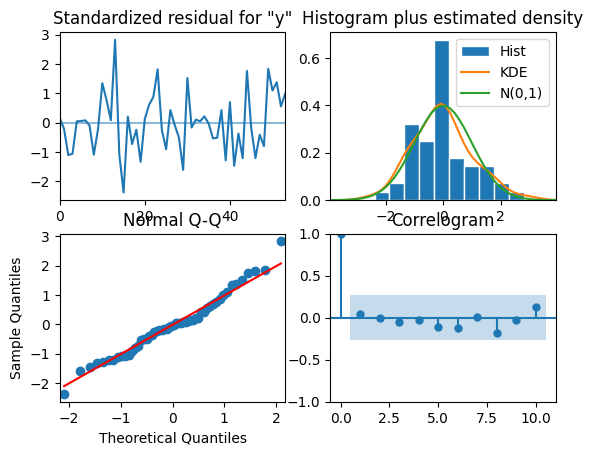

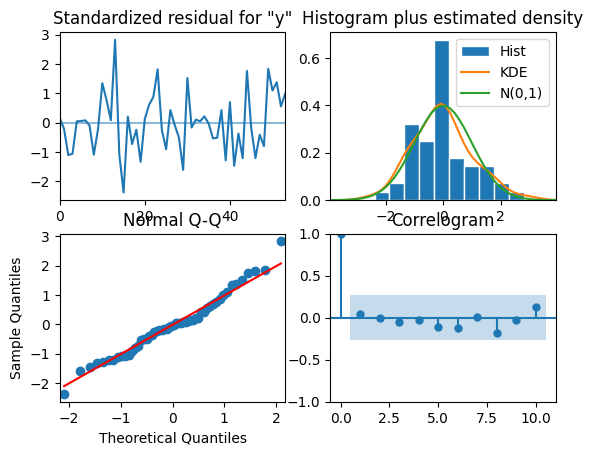

In [15]:
ARMA_fit.plot_diagnostics()

To recover the residuals, we use the *resid* attribute of the *ARIMAResults* object:

In [17]:
# Residuals
Z_residuals = ARMA_fit.resid
print(f"type(Z_residuals) = {type(Z_residuals)}")
print(f"Z_residuals.shape = {Z_residuals.shape}")

type(Z_residuals) = <class 'numpy.ndarray'>
Z_residuals.shape = (54,)


We apply the Ljung-Box test then to these residuals. We will require the function to compute the Ljung-Box statistic for 25 lags:

In [18]:
df_LjungBox = acorr_ljungbox(Z_residuals, lags = 25)

<AxesSubplot: >

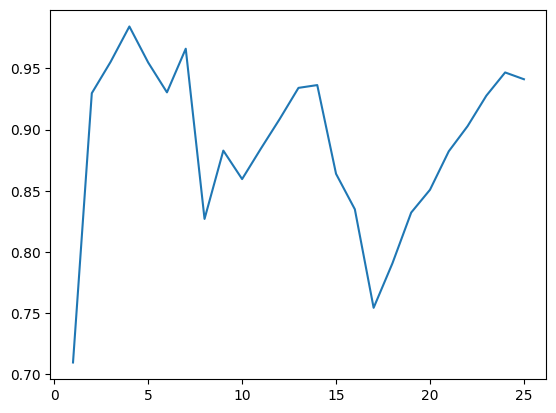

In [19]:
df_LjungBox['lb_pvalue'].plot()

For each lag, we see that the p-value is (substantially) above 0.05. Following statisticians (actually just Peixeiro's example on p.131). We will thus assume that the residuals are indeed i.i.d and follow a normal distribution.

### (e) Forecasting the differenced log returns

First, let's make the *Z_test* properly, as numpy shortens the time series by one entry.

In [20]:
# Add one element to Y_test
Y_test_ = np.empty(shape = (len(Y_test)+1,))
Y_test_[0] = Y_train[-1]
Y_test_[1:] = Y_test

# Difference
Z_test = np.diff(Y_test_)

In [23]:
# Forecast
ARMA_pred_res = ARMA_fit.get_forecast(N_test)
Z_pred = ARMA_pred_res.predicted_mean
Z_pred_conf_int = ARMA_pred_res.conf_int()

Next, we plot the 10 forecasts and their confidence intervals.

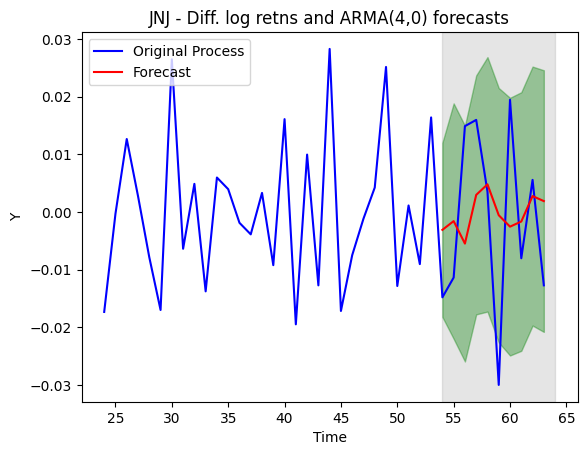

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 0.00024298581450247288


In [24]:
plot_forecasts(Y_train = Z_train,
               n_train_plot_pts = 30,
               Y_test = Z_test,
               Y_pred = Z_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Diff. log retns and ARMA(4,0) forecasts',
               legend_loc = 2,
               Y_pred_conf_int = Z_pred_conf_int,
               plot_confidence_band = True,)

This is rather interesting. The $ARMA(4,0)$ model obtained predicts that with 95% probability, our time series will take its future values in the green region. There is only one time stamp that was out of this region. 

### (f) Forecasting the JNJ close prices

Now it's a matter of transforming the forecast time series back to log returns and then to close prices. We will essentially see the same behavior.

In [25]:
# Forecasted log returns
Y_pred = np.zeros(shape = (N_test,))
Y_pred[0] =Y_train[-1]+Z_pred[0]

for i in range(N_test-1):
    Y_pred[i+1] = Y_pred[i]+Z_pred[i+1]

In [26]:
# Confidence interval
Y_pred_conf_int = np.zeros(shape = (N_test,2))
Y_pred_conf_int[0,:] =Y_train[-1]*np.ones(shape=(2,))\
                +Z_pred_conf_int[0,:]

for i in range(N_test-1):
    Y_pred_conf_int[i+1,:] = Z_pred_conf_int[i+1,:]\
                + Y_pred[i]*np.ones(shape=(2,))

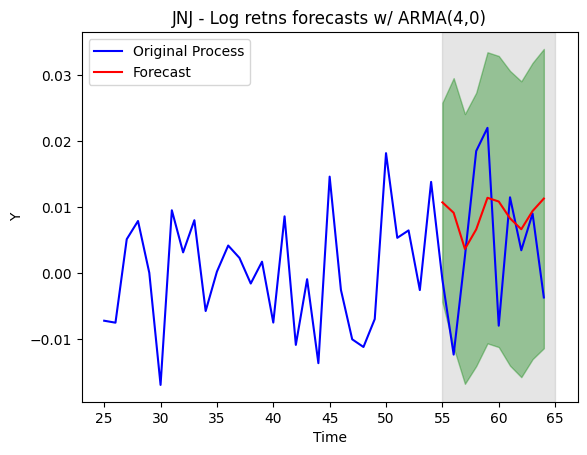

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 0.00014527281459874854


In [27]:
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 30,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Log retns forecasts w/ ARMA(4,0)',
               legend_loc = 2,
               Y_pred_conf_int = Y_pred_conf_int,
               plot_confidence_band = True,)

Now we look at the close prices.

In [28]:
# Close prices arrays of JNJ
X = df_close["JNJ"].to_numpy()
X_train = X[:-N_test]
X_test = X[-N_test:]

# Predictions
X_pred = np.zeros(shape = (N_test,))
X_pred[0] = X_train[-1]*np.exp(Y_pred[0])
for i in range(1,N_test):
    X_pred[i] = X_train[i-1]*np.exp(Y_pred[i])

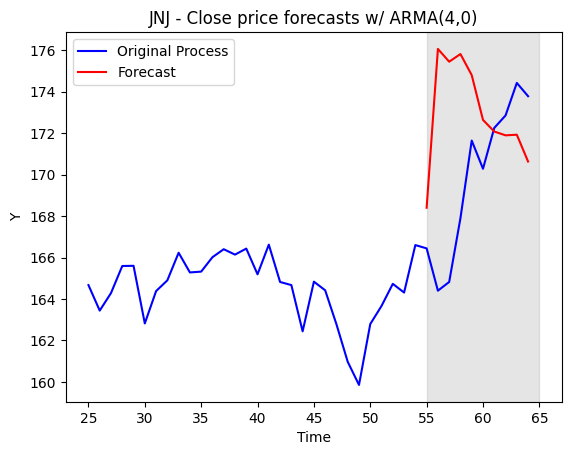

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 34.789957469737324


In [29]:
plot_forecasts(Y_train = X_train,
               n_train_plot_pts = 30,
               Y_test = X_test,
               Y_pred = X_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Close price forecasts w/ ARMA(4,0)',
               legend_loc = 2,
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

Notice that the model predicted that the close prices will rise quickly at some point in the next 10 days, and that there will be price drops later. The entirety of the prediction was thrown off by the price drop on the first forecast period, but then the prices behaved like the model predicted (with a delay).

___________________________________________________________________________

_________________________________________________________________

## E.2 - Forecasting with an $ARIMA(p,d,q)$ model

This is an illustrative example where we repeat the previous forecast, but this time we **fit the log returns directly** to an $ARIMA(4,1,0)$ object. This example is mainly an illustration of the ARIMA object of *statsmodels*.

This is how we instantiate the object and fit it:

In [30]:
# Instantiate temp model
model = ARIMA(endog = Y_train,
              order=(4, 1, 0))

# Fit the model
model_fit_res = model.fit()

In [31]:
print(model_fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   55
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 184.824
Date:                Tue, 30 May 2023   AIC                           -359.648
Time:                        00:04:38   BIC                           -349.703
Sample:                             0   HQIC                          -355.812
                                 - 55                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8884      0.127     -7.009      0.000      -1.137      -0.640
ar.L2         -0.7366      0.144     -5.127      0.000      -1.018      -0.455
ar.L3         -0.8123      0.123     -6.591      0.0

This is how we forecast the log returns:

In [32]:
# Predictions and confidence intervals
forecast_res = model_fit_res.get_forecast(N_test)
Y_pred = forecast_res.predicted_mean
Y_pred_conf_int = forecast_res.conf_int()

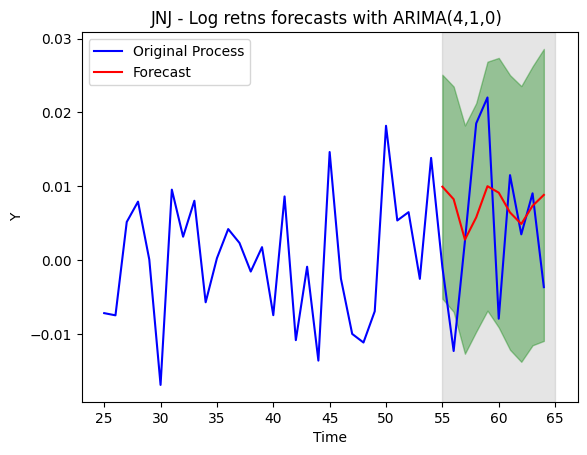

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 0.00013274003412171298


In [33]:
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 30,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Log retns forecasts with ARIMA(4,1,0) ',
               legend_loc = 2,
               Y_pred_conf_int = Y_pred_conf_int,
               plot_confidence_band = True,)

The close prices are predicted just as previously:

In [34]:
# Close prices arrays of JNJ
X = df_close["JNJ"].to_numpy()
X_train = X[:-N_test]
X_test = X[-N_test:]

# Predictions
X_pred = np.zeros(shape = (N_test,))
X_pred[0] = X_train[-1]*np.exp(Y_pred[0])
for i in range(1,N_test):
    X_pred[i] = X_train[i-1]*np.exp(Y_pred[i])

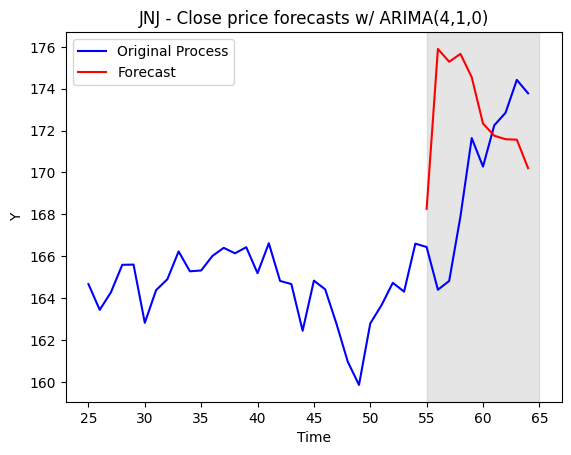

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 34.073987294202425


In [35]:
plot_forecasts(Y_train = X_train,
               n_train_plot_pts = 30,
               Y_test = X_test,
               Y_pred = X_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Close price forecasts w/ ARIMA(4,1,0)',
               legend_loc = 2,
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

In conclusion, in terms of the ARIMA API in *statsmodels*, there absolutely nothing new. We still needed to first difference the log returns after seeing that they aren't stationary.

### E.3 - The Auto ARIMA function

The R language has a built-in function called *auto_arima*, which automatically performs a grid search on the $(p,d,q)$ orders. The *statsmodels* package does not have this functionality, but a port of *auto_arima* can be found in the *pmdarima* package. See:

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

This function is actually also searching for the **seasonal** $(P,D,Q)$ orders that we will discuss elsewhere. Although this function is very useful, we need to be careful: The first execution below shows that *auto_arima* can actually **miss**:

In [36]:
# Fit the data
model = auto_arima(Y_train,
                   trace=True,
                   suppress_warnings=True,
                   seasonal=False,)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-363.812, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-369.588, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-367.598, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-367.600, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-365.588, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-368.158, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.127 seconds


This is incorrect, and we thus have to monitor the output of this function. If we specify the starting parameters $d$ and $p$ however:

In [37]:
# Fit the data
model = auto_arima(Y_train,
                   trace=True,
                   d = 1,
                   start_p = 3,
                   suppress_warnings=True,
                   seasonal=False,)

Performing stepwise search to minimize aic
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-354.394, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-323.135, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-332.773, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-325.109, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-347.724, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-356.273, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-353.206, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-351.335, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-354.143, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-333.538, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-358.174, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-356.404, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-353.854, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0]             : 

In [38]:
# Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 184.824
Date:                Tue, 30 May 2023   AIC                           -359.648
Time:                        00:15:51   BIC                           -349.703
Sample:                             0   HQIC                          -355.812
                                 - 55                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8884      0.127     -7.009      0.000      -1.137      -0.640
ar.L2         -0.7366      0.144     -5.127      0.000      -1.018      -0.455
ar.L3         -0.8123      0.123     -6.591      0.000      -1.054      -0.571
ar.L4         -0.3829      0.124     -3.081      0.002      -0.626      -0.139
sigma2      5.995e-05   1.15e-05      5.222      0.000    3.74e-05    8.24e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.88   Prob(JB):                         0.50
Heteroskedasticity (H):               0.96   Skew:                             0.38
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Which is what we obtained previously.

The forecasting method for the output of *auto_arima* is used like this:

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA.predict


In [39]:
# Make forecasts
Y_pred, Y_pred_conf_int = model.predict(n_periods=N_test, return_conf_int=True)

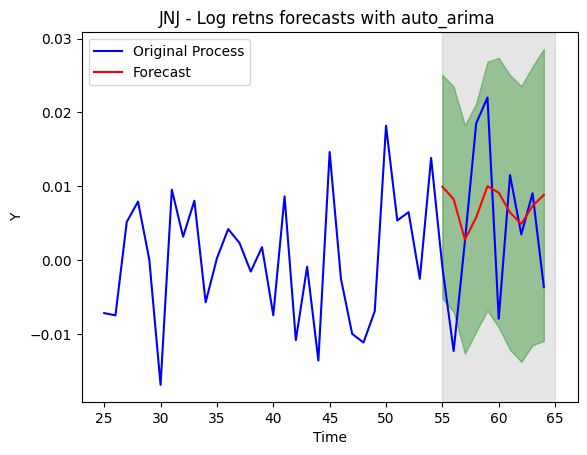

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 0.00013274003412171298


In [40]:
plot_forecasts(Y_train = Y_train,
               n_train_plot_pts = 30,
               Y_test = Y_test,
               Y_pred = Y_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Log retns forecasts with auto_arima ',
               legend_loc = 2,
               Y_pred_conf_int = Y_pred_conf_int,
               plot_confidence_band = True,)

In [41]:
# Close prices arrays of JNJ
X = df_close["JNJ"].to_numpy()
X_train = X[:-N_test]
X_test = X[-N_test:]

# Predictions
X_pred = np.zeros(shape = (N_test,))
X_pred[0] = X_train[-1]*np.exp(Y_pred[0])
for i in range(1,N_test):
    X_pred[i] = X_train[i-1]*np.exp(Y_pred[i])

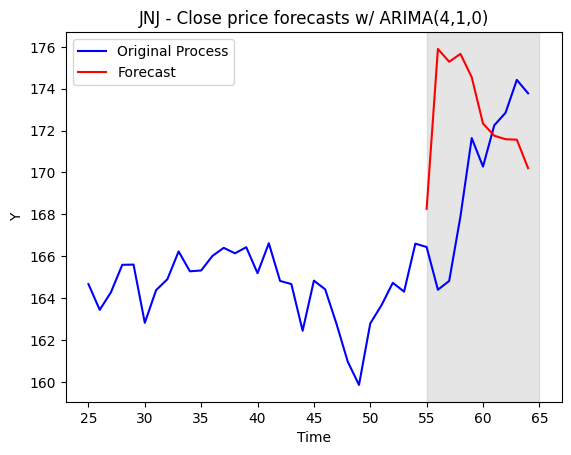

MSE over first 10 points of Y_test and Y_pred:
MSE(Y_pred[:10],Y_test[:10]) = 34.073987294202425


In [42]:
plot_forecasts(Y_train = X_train,
               n_train_plot_pts = 30,
               Y_test = X_test,
               Y_pred = X_pred,
               n_forecast_plot_pts = N_test,
               fig_title = 'JNJ - Close price forecasts w/ ARIMA(4,1,0)',
               legend_loc = 2,
               Y_pred_conf_int = None,
               plot_confidence_band = False,)

___________________________________________________________


**Continuation:** Future topics to cover are the following.
- Some thoretical complements on forecasting with statistical time series models.
- Calling R libraries from Python: The rpy2 package.
- SARIMAX: Adding seasonality and exogenous variables to the model.
- VAR and VARMA: Multivariate time series (See Lazy Programmer, cover Granjer causality).
- GARCH: Time series models for variance.
- DCC-GARCH: A multivariate version of GARCH, Dynamic Conditional Correlation.
- State space models.
- Time series models with deep learning: CNNs, RNNs.

Do not like, do not comment, and do not subscribe.